In [1]:
import pandas as pd
import numpy as np
import glob
import re
import seaborn as sns 
import matplotlib.pyplot as plt

## General visualizations of Eye tracker data health

In [2]:
data_frame = pd.read_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV.cvs")

In [3]:
data_frame.head()

Unnamed: 0  index  SubjectID  Session  SessionSubsection  \
0           0      0        479        2                  1   
1           1      1        479        2                  1   
2           2      2        479        2                  1   
3           3      3        479        2                  1   
4           4      4        479        2                  1   

   timeStampDataPointEnd  combinedGazeValidityBitmask  \
0           1.653045e+09                            3   
1           1.653045e+09                            3   
2           1.653045e+09                            3   
3           1.653045e+09                            3   
4           1.653045e+09                            3   

   eyePositionCombinedWorld.x  eyePositionCombinedWorld.y  \
0                  -59.134151                    2.259476   
1                  -59.134151                    2.259476   
2                  -59.134151                    2.259476   
3                  -59.138134                    2.259230   
4                  -59.138134                    2.259230   

   eyePositionCombinedWorld.z  ...  corrected_vel  events    length  \
0                   34.714977  ...            NaN     NaN       NaN   
1                   34.714977  ...            NaN     2.0  0.011905   
2                   34.714977  ...            NaN    -2.0  0.011905   
3                   34.714943  ...      27.383014    -1.0  0.011408   
4                   34.714912  ...       3.578448     2.0  0.254944   

    distance   avg_dist         names  Collider_CategoricalN  Unnamed: 0.1.1  \
0        NaN        NaN  Building_161               Building             NaN   
1  62.645712  62.645712  Building_161               Building             NaN   
2  62.645712  62.645712  Building_161               Building             NaN   
3        NaN        NaN  Building_161               Building             NaN   
4  62.709433  62.709424  Building_161               Building             NaN   

  Unnamed: 0.1.1.1 Unnamed: 0.1.1.1.1  
0              NaN                NaN  
1              NaN                NaN  
2              NaN                NaN  
3              NaN                NaN  
4              NaN                NaN  

[5 rows x 49 columns]

In [7]:
# We are excluding two participants because they were exposed to Vincent's experiment
Mask_IDs = data_frame['SubjectID'].isin([ 5238, 8695])
data_frame = data_frame.loc[~Mask_IDs]

In [8]:
data_frame.combinedGazeValidityBitmask.value_counts(normalize=True)

3    0.939948
0    0.060052
Name: combinedGazeValidityBitmask, dtype: float64

In [9]:
Blinks = pd.DataFrame(data_frame.groupby(["SubjectID", "Session"])["combinedGazeValidityBitmask"].value_counts(normalize=True))
Blinks.rename(columns ={"combinedGazeValidityBitmask": "Percentage"}, inplace=True)
Blinks.reset_index(inplace=True)
Blinks.loc[:, 'Validity'] = Blinks['combinedGazeValidityBitmask'].replace( {3:"Valid", 0:"Invalid"})

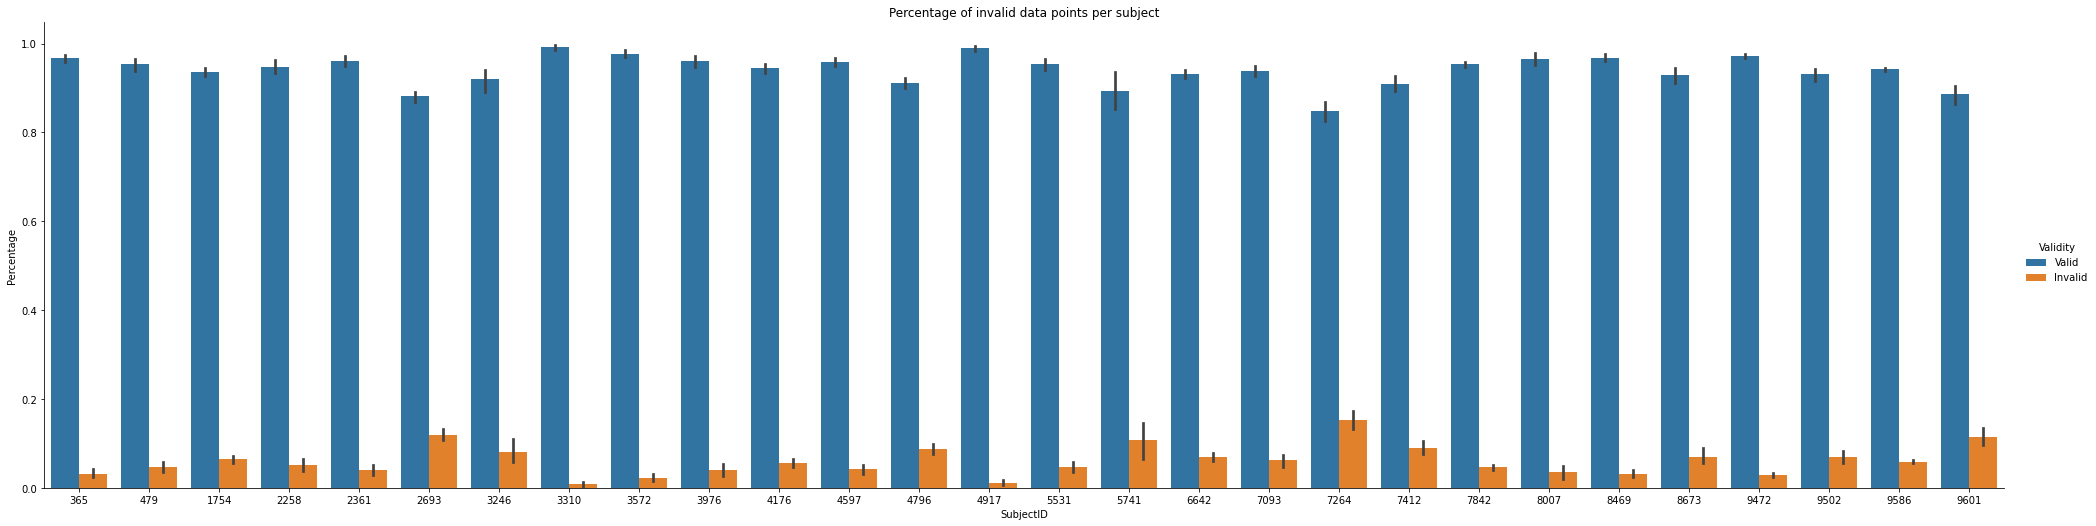

In [10]:
sns.catplot(data=Blinks, hue="Validity", y="Percentage", x="SubjectID", kind="bar", \
            height=7, aspect=4).set(title="Percentage of invalid data points per subject")

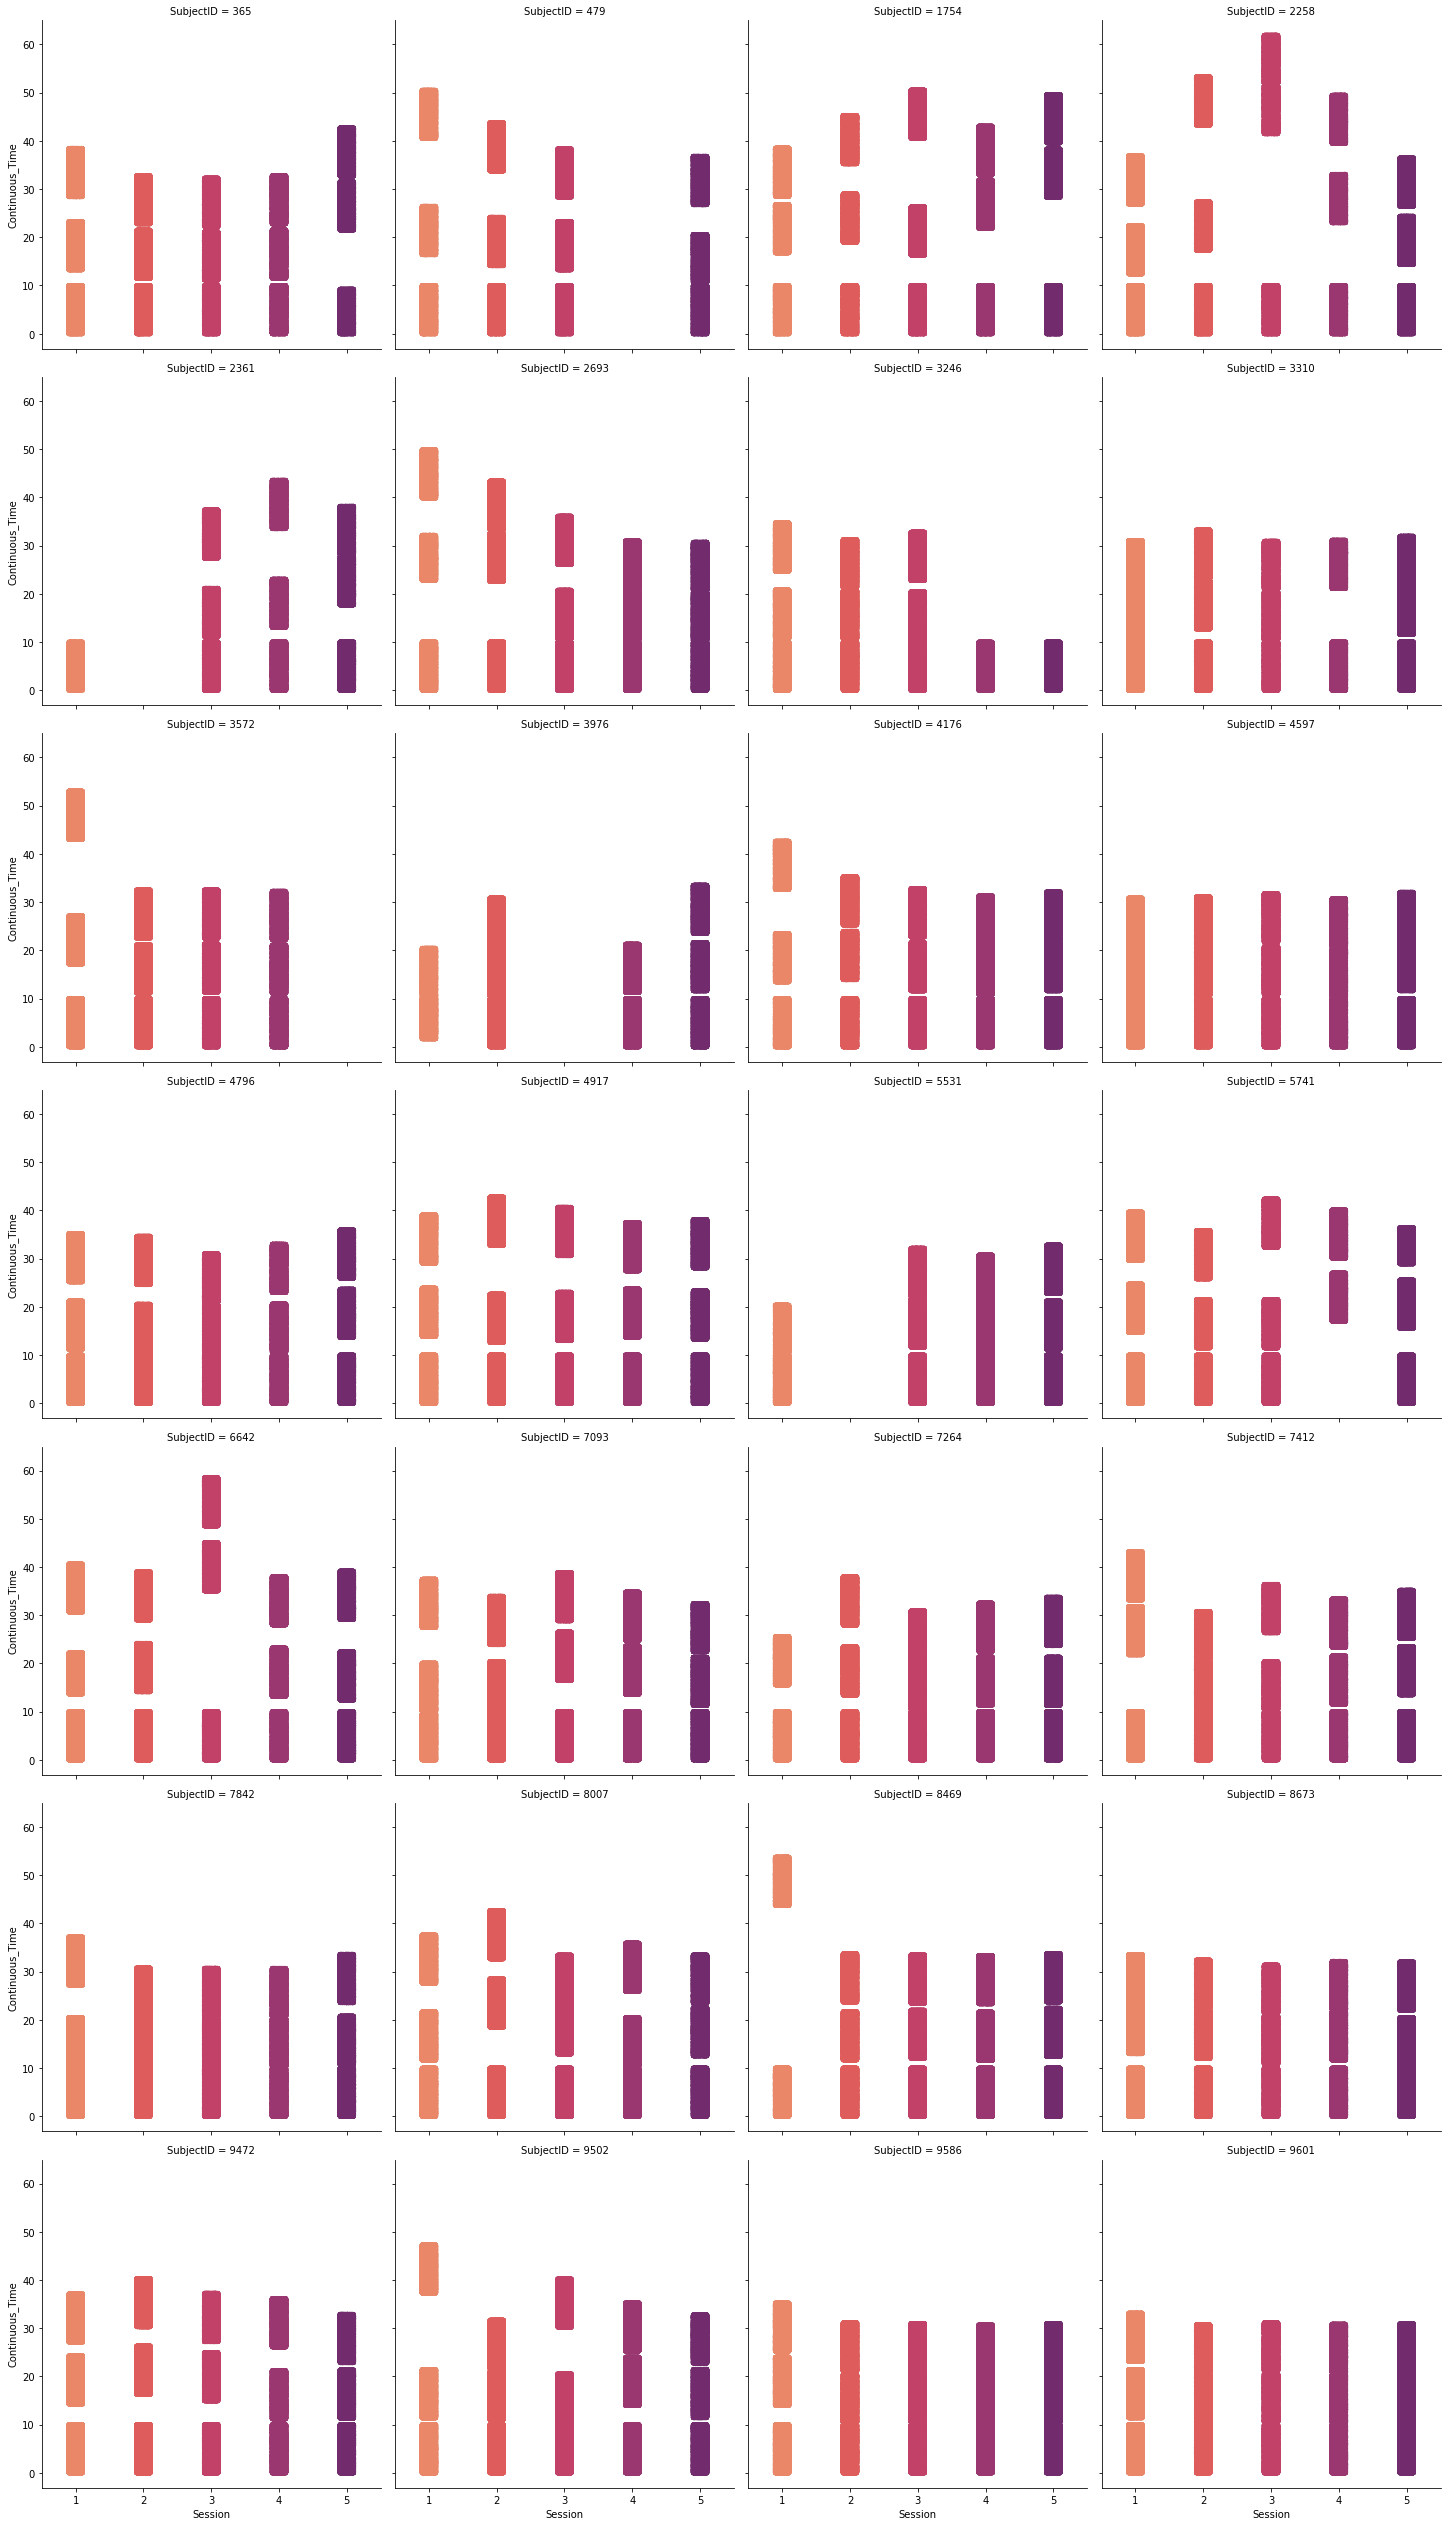

In [11]:
plot = data_frame[data_frame.Continuous_Time < 120]
sns.catplot(data=plot, col="SubjectID", y="Continuous_Time", x="Session",  col_wrap=4, palette="flare")

## Gaze processing

In [12]:
# Take  final row per fixation (the duration, average distance is the same all through the rows of the same fixation)
gaze = data_frame[data_frame.events == -2].copy()

### Get all gazes whose duration is more than 3.5 median standard deviations out 

In [13]:
gaze["Median_Standard_Duration"] = np.nanmedian(abs(gaze.length - np.nanmedian(gaze.length))) * 1.4826
gaze.loc[:, "gaze_mad_z"] = abs(gaze.length.tolist() - np.nanmedian(gaze.length)) / gaze.Median_Standard_Duration.tolist()
gaze.loc[:,"Outlier_Gaze_Length"] = np.where(gaze["gaze_mad_z"] > 3.5, "Out", "Stays")
gaze_no_out = gaze[gaze.Outlier_Gaze_Length != "Out"].copy()
gaze_no_out.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV_NO_Outliers.cvs")

In [14]:
gaze.Outlier_Gaze_Length.value_counts(normalize=True)

Stays    0.949539
Out      0.050461
Name: Outlier_Gaze_Length, dtype: float64

In [15]:
# See how many data points we're loosing by excluding outliers 
display(gaze.shape)
display(gaze_no_out.shape)

(760146, 52)

(721788, 52)

### Gaze Visualizations on complete data 

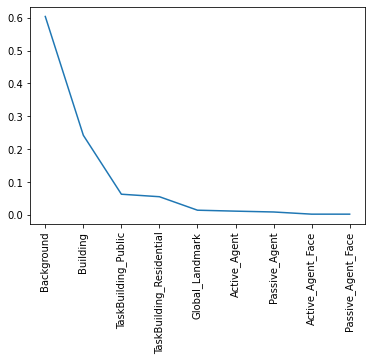

In [17]:
ax = gaze_no_out.Collider_CategoricalN.value_counts(normalize=True).plot()
ax.tick_params(axis='x', labelrotation = 90)

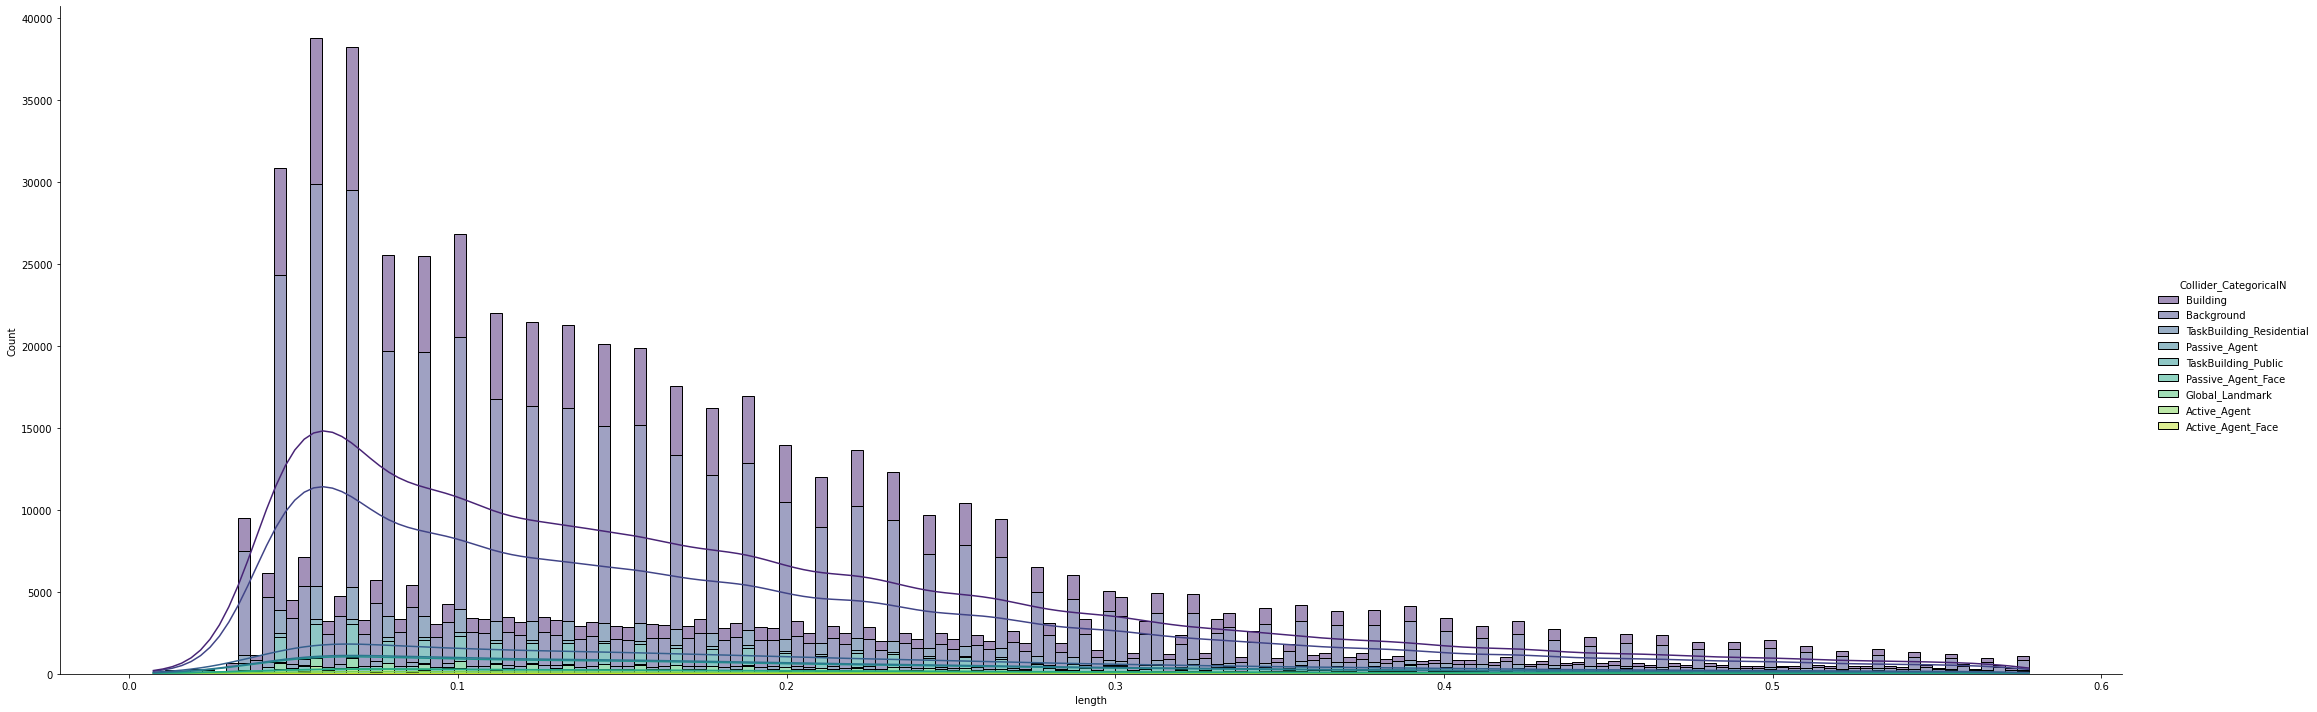

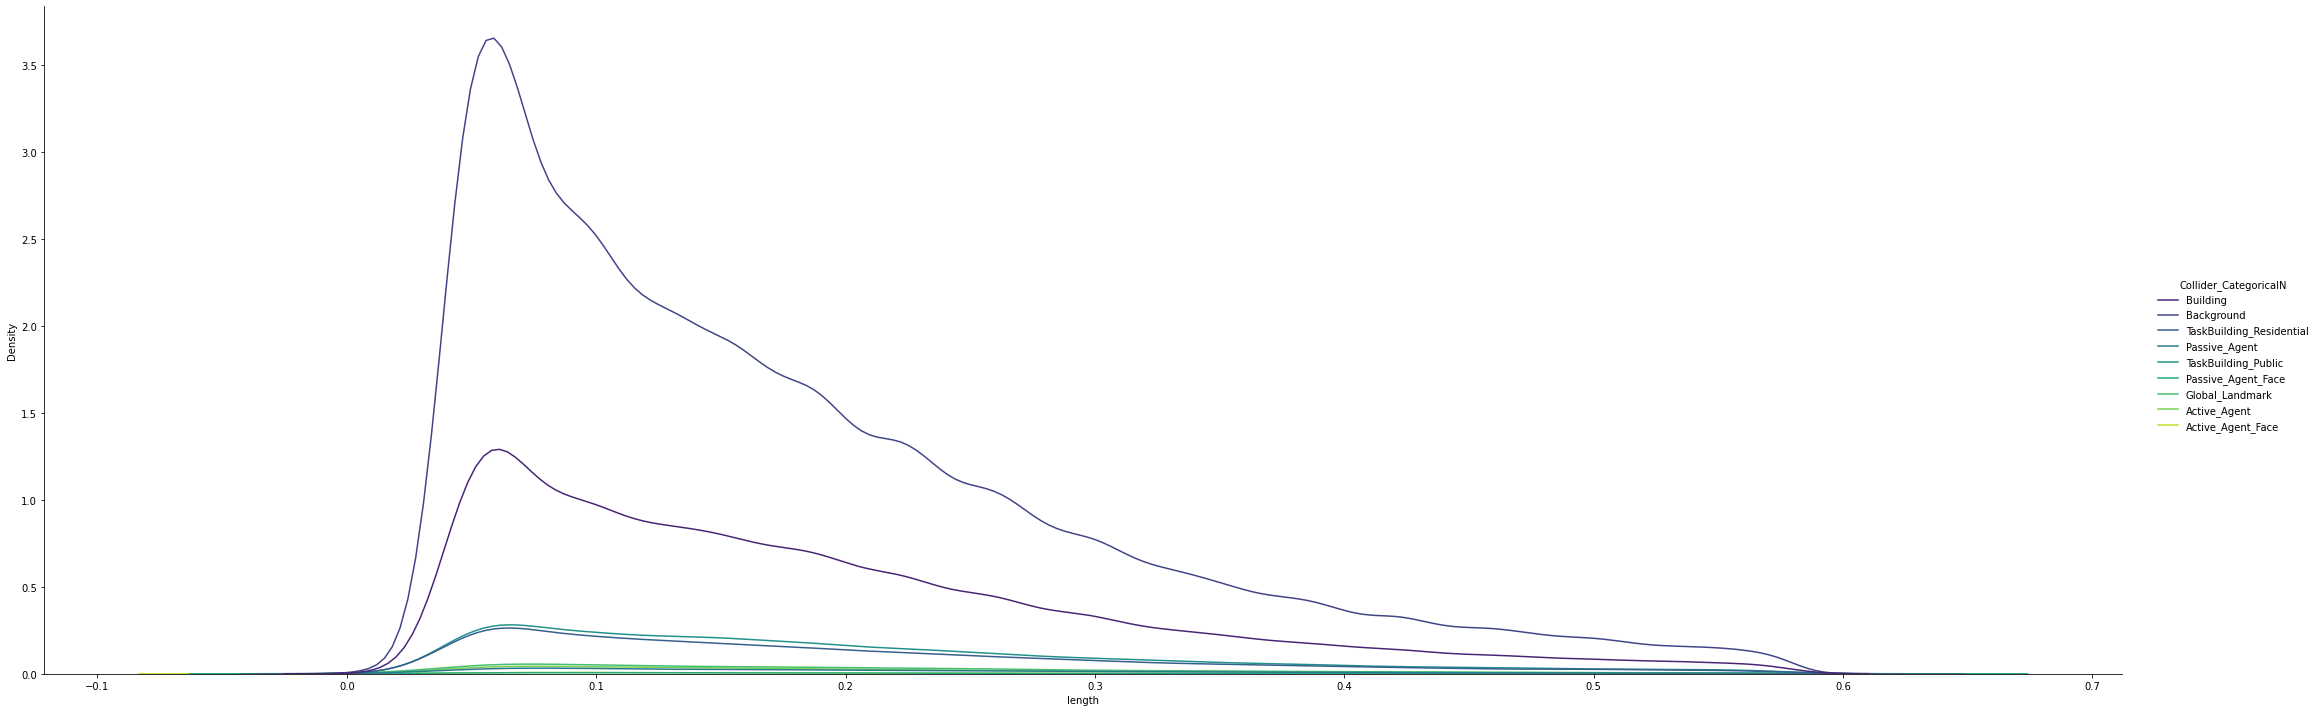

In [18]:
sns.displot(x='length', hue="Collider_CategoricalN",
             data=gaze_no_out, 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='length', hue="Collider_CategoricalN",
             data=gaze_no_out, 
            height=10, aspect= 3, kind="kde", palette="viridis")

In [24]:
# Since the collider names are too detailed, here we create a dictionary with patterns to classify them into our categories of interest
patterns = {'\d{2}_Sa':'Passive_Agent', '\d{2}_Cma':'Active_Agent', 'Building_\d+': 'Building'}
patterns.update(dict.fromkeys(['Castle-TaskBuilding_56', 'Crane_59','HighSilo-TaskBuilding_49', 'Windmill-TaskBuilding_10_1', 'Church-TaskBuilding_16'], 'Global_Landmark'))
patterns.update(dict.fromkeys(['^TaskBuilding_2$','^TaskBuilding_3$', '^TaskBuilding_5$', '^TaskBuilding_8$', '^TaskBuilding_9$', '^TaskBuilding_11$', '^TaskBuilding_13$', '^TaskBuilding_14$', '^TaskBuilding_20$', 
                               '^TaskBuilding_21$', '^TaskBuilding_23$','^TaskBuilding_27$', '^TaskBuilding_29$', '^TaskBuilding_32$', '^TaskBuilding_34$',  '^TaskBuilding_38$', '^TaskBuilding_41$', '^TaskBuilding_42$', 
                               '^TaskBuilding_44$', '^TaskBuilding_45$', '^TaskBuilding_47$', '^TaskBuilding_50$', '^TaskBuilding_51$', '^TaskBuilding_52$', 'BasketballCourt_58', 'Construction_57', 
                               '^Graffity_02$', '^Graffity_03$', '^Graffity_05$', '^Graffity_08$', '^Graffity_09$', '^Graffity_11$', '^Graffity_13$', '^Graffity_14$', '^Graffity_20$', 
                               '^Graffity_21$', '^Graffity_23$', '^Graffity_27$', '^Graffity_29$', '^Graffity_32$', '^Graffity_34$', '^Graffity_38$', '^Graffity_41$', '^Graffity_42$', 
                               '^Graffity_44$', '^Graffity_45$', '^Graffity_47$',  '^Graffity_50$', '^Graffity_51$', '^Graffity_52$'], 'TaskBuilding_Public'))

patterns.update(dict.fromkeys(['^TaskBuilding_1$','^TaskBuilding_4$', '^TaskBuilding_6$', '^TaskBuilding_7$', '^TaskBuilding_12$', '^TaskBuilding_15$', '^TaskBuilding_17$', '^TaskBuilding_18$', '^TaskBuilding_19$', 
                               '^TaskBuilding_22$', '^TaskBuilding_24$','^TaskBuilding_25$', '^TaskBuilding_26$', '^TaskBuilding_28$', '^TaskBuilding_30$',  '^TaskBuilding_31$', '^TaskBuilding_33$', '^TaskBuilding_35$', 
                               '^TaskBuilding_36$', '^TaskBuilding_37$', '^TaskBuilding_39$', '^TaskBuilding_40$', '^TaskBuilding_43$', '^TaskBuilding_48$', '^TaskBuilding_54$','^TaskBuilding_55$',
                               '^Graffity_01$','^Graffity_04$', '^Graffity_06$', '^Graffity_07$', '^Graffity_12$', '^Graffity_15$', '^Graffity_17$', '^Graffity_18$', '^Graffity_19$', '^Graffity_22$', 
                               '^Graffity_24$','^Graffity_25$', '^Graffity_26$', '^Graffity_28$', '^Graffity_30$',  '^Graffity_31$', '^Graffity_33$', '^Graffity_35$', '^Graffity_36$', '^Graffity_37$', '^Graffity_39$', 
                               '^Graffity_40$', '^Graffity_43$', '^Graffity_48$', '^Graffity_54$', '^Graffity_55$' ], 'TaskBuilding_Residential'))
default_val = 'Background'

In [30]:
gaze_no_out["Collider_CategoricalN"] =  gaze_no_out['names'].apply(lambda x: next((val for key, val in patterns.items() if re.match(key, x)), default_val))
#string_to_add = "_Face"
# Define the condition and the string to add
#Mask_1f = ((data_frame_gaze_no_out_ONLY_TEST['Collider_CategoricalN'] == "Active_Agent") & (data_frame_gaze_no_out_ONLY_TEST['Face_Hits'] == "Face")) | ((data_frame_gaze_no_out_ONLY_TEST['Collider_CategoricalN'] == "Passive_Agent") & (data_frame_gaze_no_out_ONLY_TEST['Face_Hits'] == "Face"))
#data_frame_gaze_no_out_ONLY_TEST.loc[Mask_1f, 'Collider_CategoricalN'] = data_frame_gaze_no_out_ONLY_TEST.loc[Mask_1f, 'Collider_CategoricalN'] + string_to_add

In [31]:
#Keep only the gazes that happened on the categories of interest
data_frame_gaze_no_out_ONLY_TEST = gaze_no_out[(gaze_no_out.Collider_CategoricalN != "Background") & (gaze_no_out.Collider_CategoricalN != "Building")].copy()

In [32]:
data_frame_gaze_no_out_ONLY_TEST.Collider_CategoricalN.value_counts(normalize=True)

TaskBuilding_Public         0.389936
TaskBuilding_Residential    0.371032
Global_Landmark             0.089991
Active_Agent                0.082838
Passive_Agent               0.066202
Name: Collider_CategoricalN, dtype: float64

In [33]:
data_frame_gaze_no_out_ONLY_TEST.head()

Unnamed: 0  index  SubjectID  Session  SessionSubsection  \
159         159    159        479        2                  1   
210         210    210        479        2                  1   
224         224    224        479        2                  1   
238         238    238        479        2                  1   
253         253    253        479        2                  1   

     timeStampDataPointEnd  combinedGazeValidityBitmask  \
159           1.653045e+09                            0   
210           1.653045e+09                            3   
224           1.653045e+09                            3   
238           1.653045e+09                            3   
253           1.653045e+09                            3   

     eyePositionCombinedWorld.x  eyePositionCombinedWorld.y  \
159                  -59.116585                    2.262560   
210                  -59.121014                    2.269164   
224                  -59.145859                    2.272603   
238                  -59.124584                    2.283468   
253                  -59.142059                    2.288404   

     eyePositionCombinedWorld.z  ...   distance   avg_dist            names  \
159                   34.702782  ...  10.420032  10.422815  TaskBuilding_35   
210                   34.681396  ...  10.886178  10.879393  TaskBuilding_35   
224                   34.664337  ...   7.238938   7.239133            46_Sa   
238                   34.640255  ...  12.199331  12.183309      Graffity_35   
253                   34.623589  ...  12.443347  12.447341      Graffity_35   

        Collider_CategoricalN  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
159  TaskBuilding_Residential             NaN               NaN   
210  TaskBuilding_Residential             NaN               NaN   
224             Passive_Agent             NaN               NaN   
238  TaskBuilding_Residential             NaN               NaN   
253  TaskBuilding_Residential             NaN               NaN   

     Unnamed: 0.1.1.1.1  Median_Standard_Duration gaze_mad_z  \
159                 NaN                  0.120601   0.185065   
210                 NaN                  0.120601   0.555213   
224                 NaN                  0.120601   0.279669   
238                 NaN                  0.120601   0.004096   
253                 NaN                  0.120601   0.551115   

    Outlier_Gaze_Length  
159               Stays  
210               Stays  
224               Stays  
238               Stays  
253               Stays  

[5 rows x 52 columns]

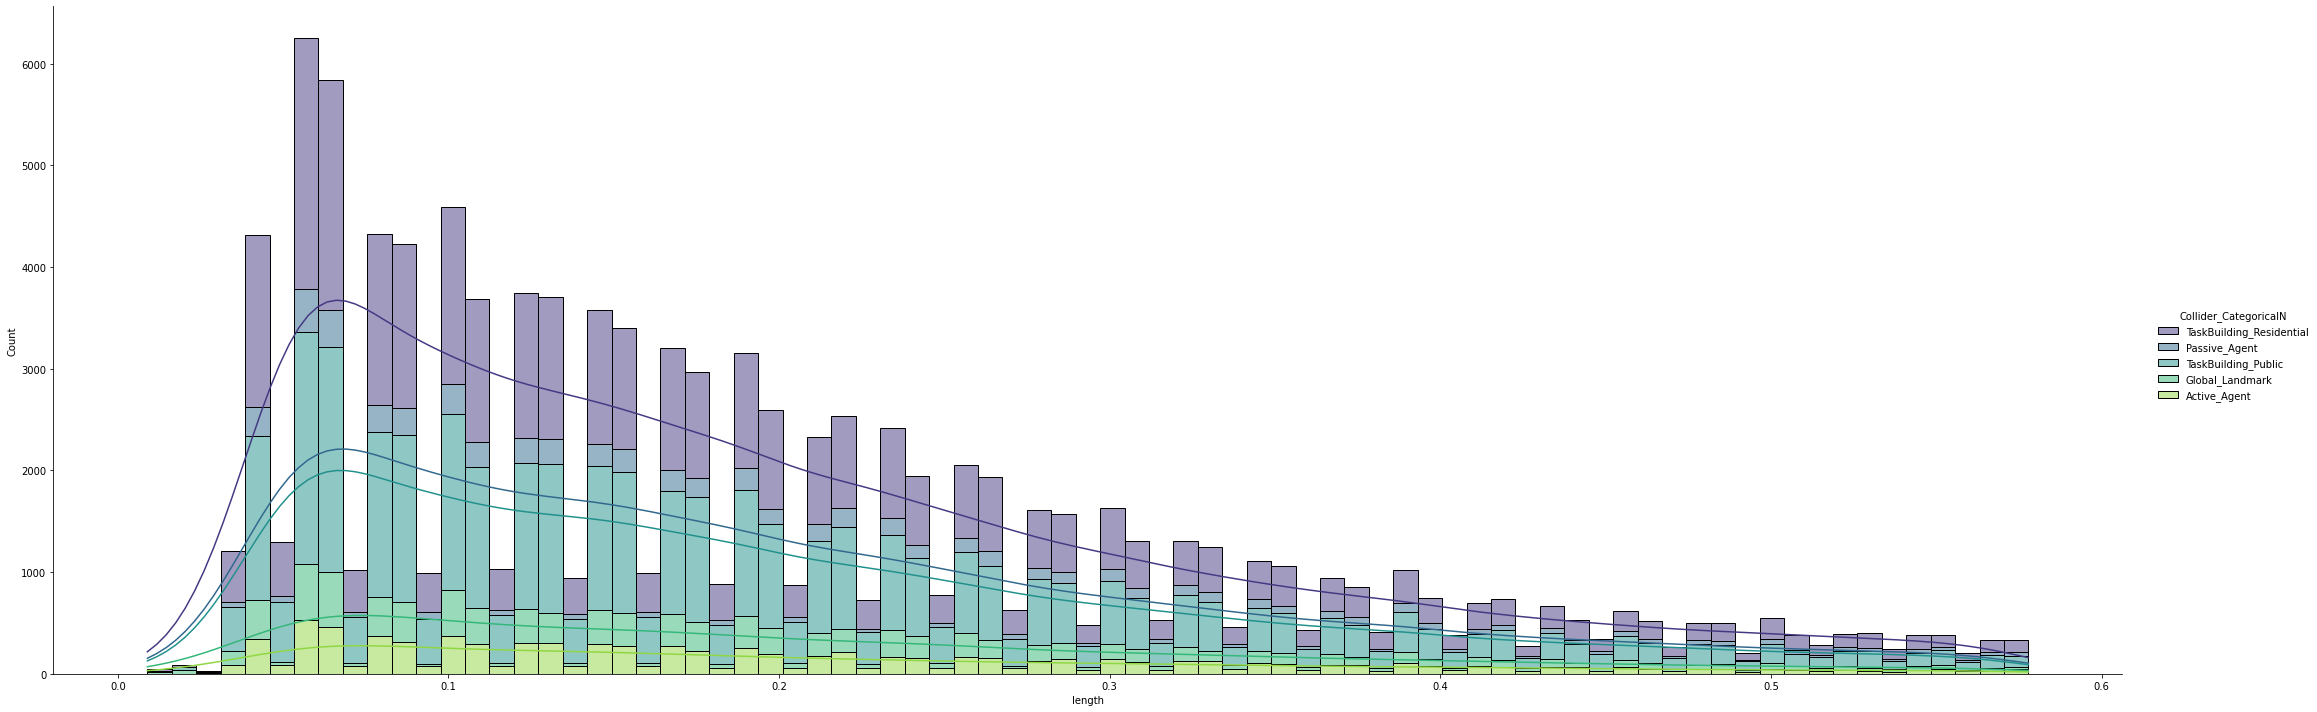

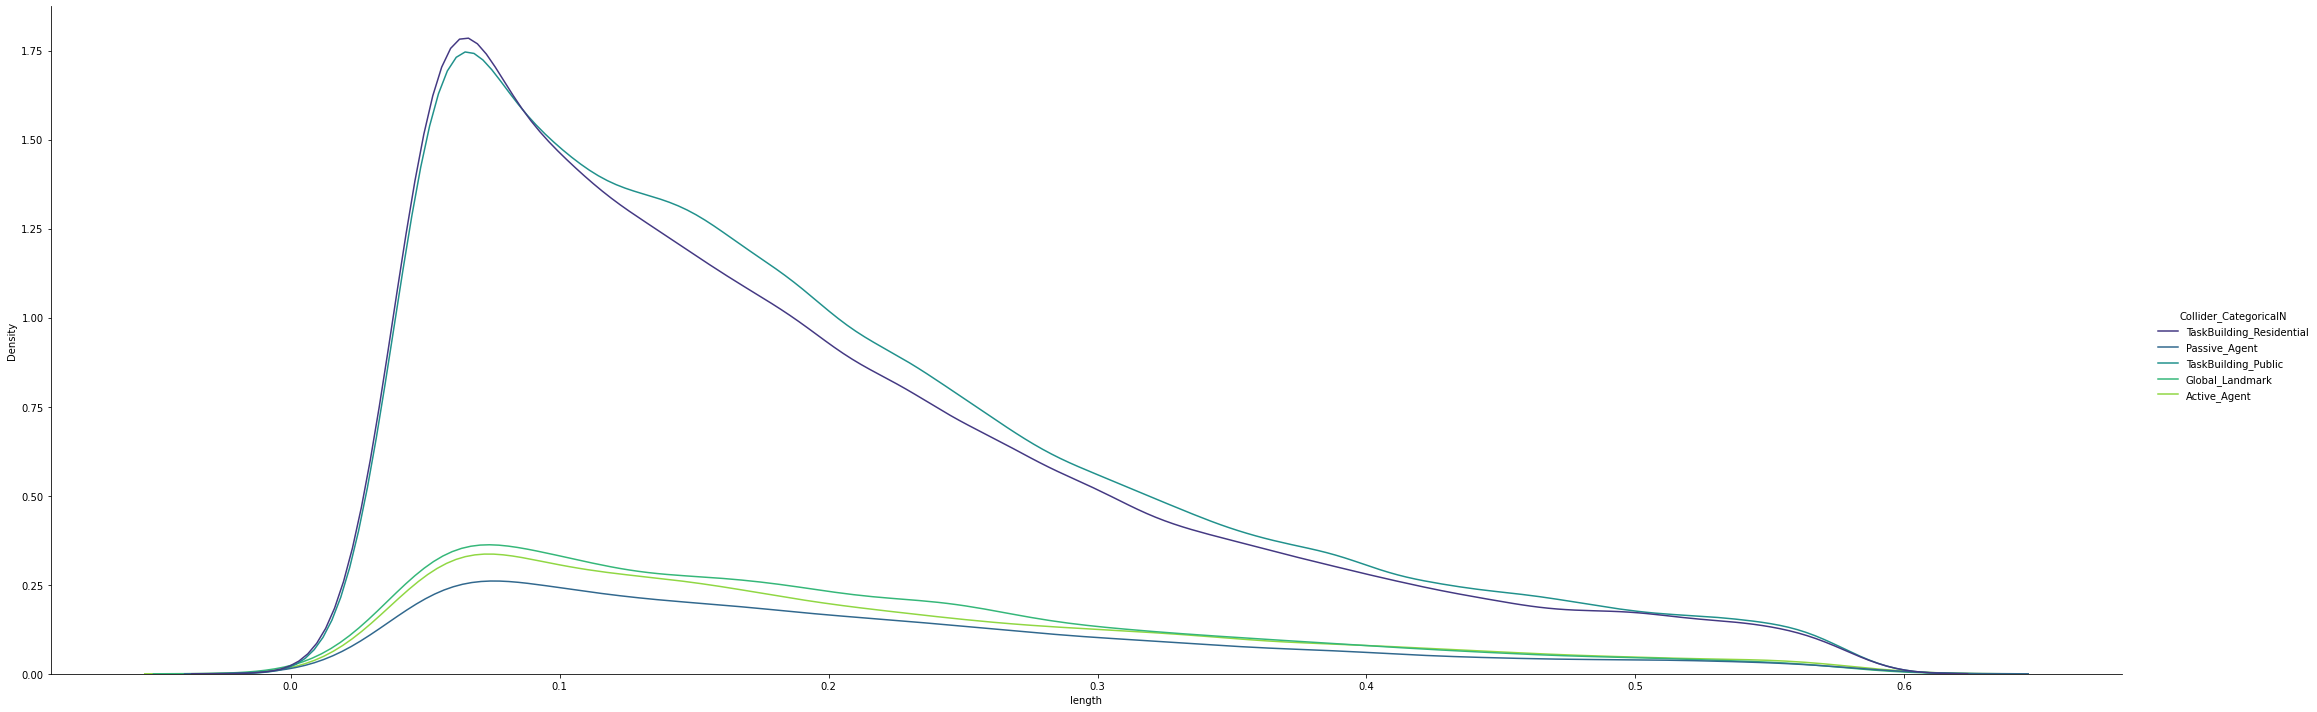

In [34]:
sns.displot(x='length', hue="Collider_CategoricalN",
             data=data_frame_gaze_no_out_ONLY_TEST, 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='length', hue="Collider_CategoricalN",
             data=data_frame_gaze_no_out_ONLY_TEST, 
            height=10, aspect= 3, kind="kde", palette="viridis")

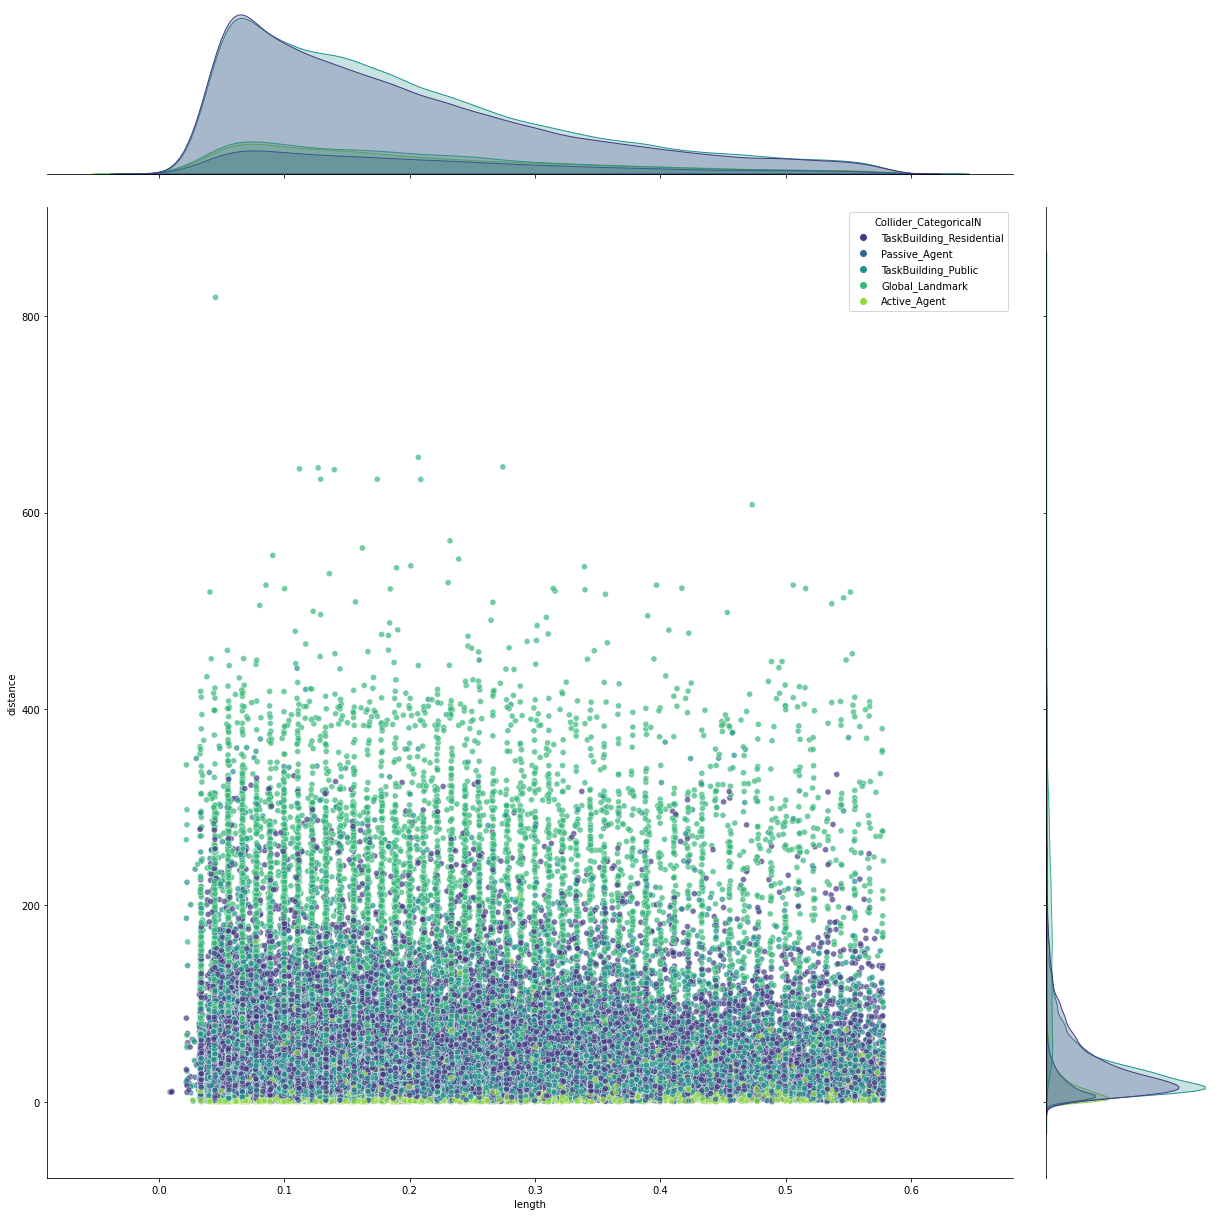

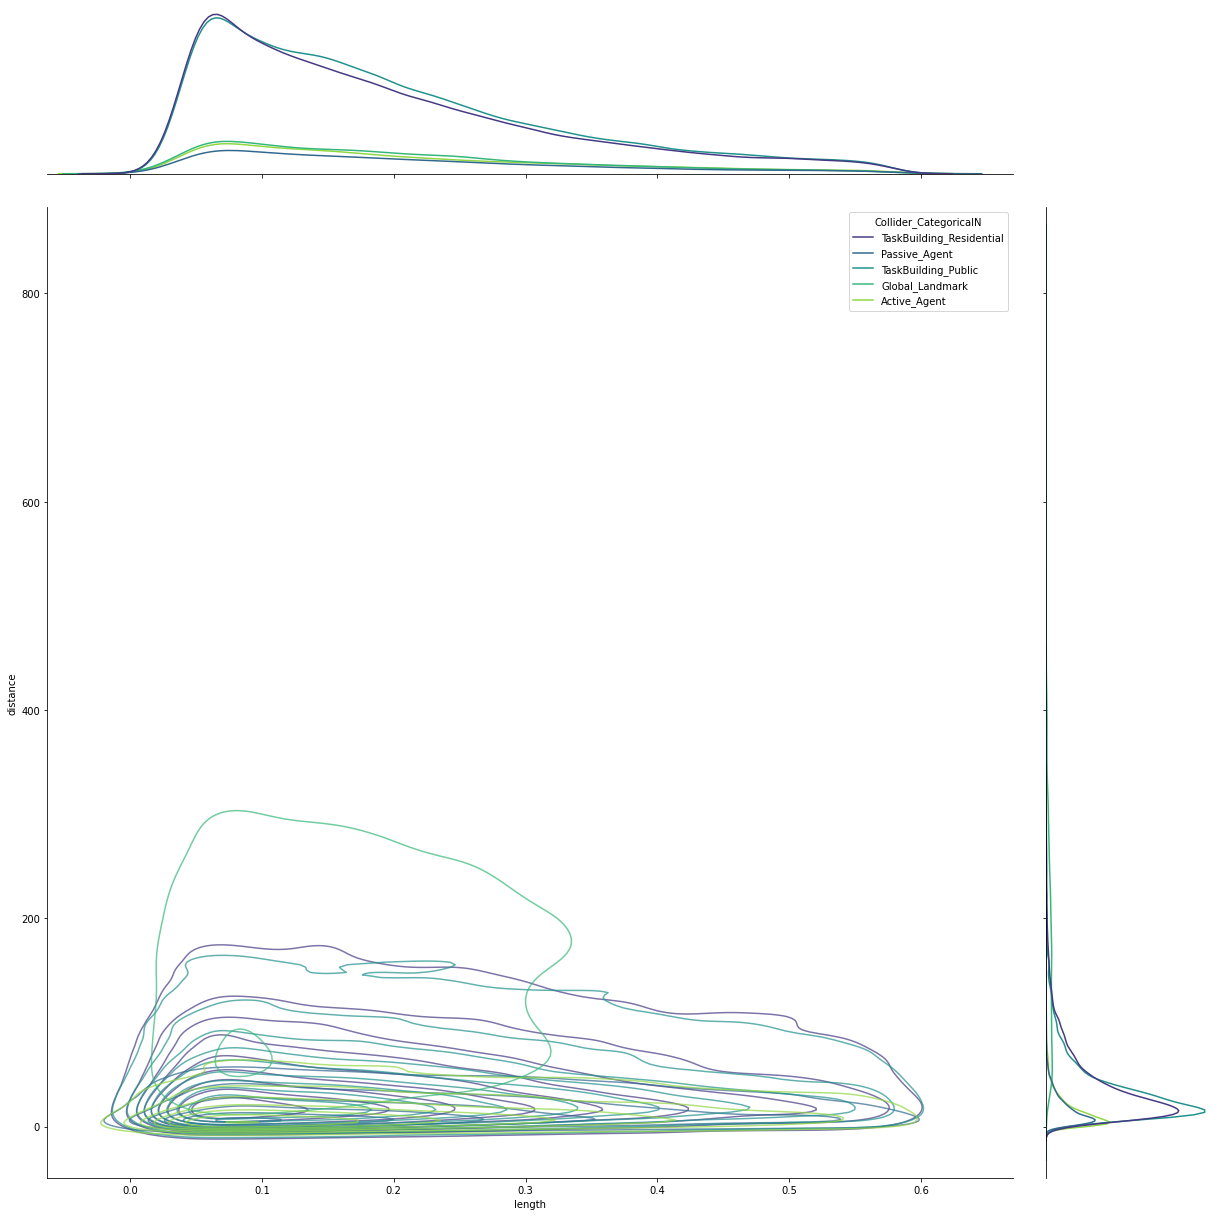

In [35]:
sns.jointplot(data=data_frame_gaze_no_out_ONLY_TEST, y="distance", x="length", hue="Collider_CategoricalN",  height=17, alpha=0.7, palette="viridis")
sns.jointplot(data=data_frame_gaze_no_out_ONLY_TEST, y="distance", x="length", hue="Collider_CategoricalN",  height=17, alpha=0.7, palette="viridis",  kind="kde")

In [42]:
# Create a Dictionary that identifies agent, graffity and house into this three categories
patterns2 = {'\d{2}_Sa':'Agent', '\d{2}_Cma':'Agent', '^TaskBuilding_': 'Building', 'BasketballCourt_58': 'Building', '^Graffity':'Graffity'}
patterns2.update(dict.fromkeys(['Castle-TaskBuilding_56', 'Crane_59','HighSilo-TaskBuilding_49', 'Windmill-TaskBuilding_10_1', 'Church-TaskBuilding_16'], 'Global_Landmark'))

In [43]:
data_frame_gaze_no_out_ONLY_TEST['Hit_Object_Category'] = data_frame_gaze_no_out_ONLY_TEST['names'].apply(lambda x: next((val for key, val in patterns2.items() if re.match(key, x)), default_val))    

In [44]:
data_frame_gaze_no_out_ONLY_TEST = data_frame_gaze_no_out_ONLY_TEST.loc[:, ~data_frame_gaze_no_out_ONLY_TEST.columns.str.contains('^Unnamed')]
data_frame_gaze_no_out_ONLY_TEST.head()

index  SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
159    159        479        2                  1           1.653045e+09   
210    210        479        2                  1           1.653045e+09   
224    224        479        2                  1           1.653045e+09   
238    238        479        2                  1           1.653045e+09   
253    253        479        2                  1           1.653045e+09   

     combinedGazeValidityBitmask  eyePositionCombinedWorld.x  \
159                            0                  -59.116585   
210                            3                  -59.121014   
224                            3                  -59.145859   
238                            3                  -59.124584   
253                            3                  -59.142059   

     eyePositionCombinedWorld.y  eyePositionCombinedWorld.z  \
159                    2.262560                   34.702782   
210                    2.269164                   34.681396   
224                    2.272603                   34.664337   
238                    2.283468                   34.640255   
253                    2.288404                   34.623589   

     eyeDirectionCombinedWorld.y  ...    length   distance   avg_dist  \
159                    -1.076677  ...  0.133425  10.420032  10.422815   
210                     0.102463  ...  0.088784  10.886178  10.879393   
224                    -0.013656  ...  0.122015   7.238938   7.239133   
238                     0.221266  ...  0.155250  12.199331  12.183309   
253                     0.298437  ...  0.222209  12.443347  12.447341   

               names     Collider_CategoricalN  Median_Standard_Duration  \
159  TaskBuilding_35  TaskBuilding_Residential                  0.120601   
210  TaskBuilding_35  TaskBuilding_Residential                  0.120601   
224            46_Sa             Passive_Agent                  0.120601   
238      Graffity_35  TaskBuilding_Residential                  0.120601   
253      Graffity_35  TaskBuilding_Residential                  0.120601   

     gaze_mad_z Outlier_Gaze_Length Hit_Object_Category          recoded  
159    0.185065               Stays            Building  TaskBuilding_35  
210    0.555213               Stays            Building  TaskBuilding_35  
224    0.279669               Stays               Agent            46_Sa  
238    0.004096               Stays            Graffity  TaskBuilding_35  
253    0.551115               Stays            Graffity  TaskBuilding_35  

[5 rows x 50 columns]

### Recode to count the graffity as the house hit 

In [45]:
# Map graffity into the name of the building that it's in front of 
Graffity_mapping = {'Graffity_14':'TaskBuilding_14', 
                  'Graffity_41': 'TaskBuilding_41',
                  'Graffity_02': 'TaskBuilding_2', 
                  'Graffity_47': 'TaskBuilding_47',
                  'Graffity_20': 'TaskBuilding_20',
                  'Graffity_09': 'TaskBuilding_9',
                  'Graffity_50': 'TaskBuilding_50',
                  'Graffity_45': 'TaskBuilding_45',
                  'Graffity_08': 'TaskBuilding_8',
                  'Graffity_27': 'TaskBuilding_27',
                  'Graffity_51': 'TaskBuilding_51',
                  'Graffity_03': 'TaskBuilding_3',
                  'Graffity_11': 'TaskBuilding_11',
                  'Graffity_42': 'TaskBuilding_42',
                  'Graffity_23': 'TaskBuilding_23',
                  'Graffity_52': 'TaskBuilding_52',
                  'Graffity_38': 'TaskBuilding_38',
                  'Graffity_34': 'TaskBuilding_34',
                  'Graffity_05': 'TaskBuilding_5',
                  'Graffity_29': 'TaskBuilding_29',
                  'Graffity_32': 'TaskBuilding_32',
                  'Graffity_13': 'TaskBuilding_13',
                  'Graffity_44': 'TaskBuilding_44',
                  'Graffity_21': 'TaskBuilding_21',
                  'Graffity_04': 'TaskBuilding_4',
                  'Graffity_01': 'TaskBuilding_1',
                  'Graffity_06': 'TaskBuilding_6',
                  'Graffity_07': 'TaskBuilding_7',  
                  'Graffity_17': 'TaskBuilding_17', 
                  'Graffity_15': 'TaskBuilding_15',
                  'Graffity_12': 'TaskBuilding_12',
                  'Graffity_18': 'TaskBuilding_18',
                  'Graffity_19': 'TaskBuilding_19',
                  'Graffity_22': 'TaskBuilding_22',
                  'Graffity_24': 'TaskBuilding_24',
                  'Graffity_25': 'TaskBuilding_25',
                  'Graffity_26': 'TaskBuilding_26',
                  'Graffity_28': 'TaskBuilding_28',
                  'Graffity_30': 'TaskBuilding_30',
                  'Graffity_31': 'TaskBuilding_31',
                  'Graffity_33': 'TaskBuilding_33',
                  'Graffity_35': 'TaskBuilding_35',
                  'Graffity_36': 'TaskBuilding_36',
                  'Graffity_37': 'TaskBuilding_37',
                  'Graffity_39': 'TaskBuilding_39',
                  'Graffity_40': 'TaskBuilding_40',
                  'Graffity_43': 'TaskBuilding_43',
                  'Graffity_48': 'TaskBuilding_48',
                  'Graffity_54': 'TaskBuilding_54',
                  'Graffity_55': 'TaskBuilding_55'
             }

In [46]:
data_frame_gaze_no_out_ONLY_TEST.loc[:, 'recoded'] = data_frame_gaze_no_out_ONLY_TEST.loc[:,'names']
data_frame_gaze_no_out_ONLY_TEST['recoded'].replace(Graffity_mapping, inplace=True)

In [47]:
data_frame_gaze_no_out_ONLY_TEST["Collider_CategoricalN"] =  data_frame_gaze_no_out_ONLY_TEST['recoded'].apply(lambda x: next((val for key, val in patterns.items() if re.match(key, x)), default_val))

## Cummulative sum calculation

In [50]:
data_frame_gaze_no_out_ONLY_TEST["cumsum_length"] = data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID", "recoded", "Collider_CategoricalN"])['length'].cumsum()

In [51]:
data_frame_gaze_no_out_ONLY_TEST.head(20)

index  SubjectID  Session  SessionSubsection  timeStampDataPointEnd  \
159     159        479        2                  1           1.653045e+09   
210     210        479        2                  1           1.653045e+09   
224     224        479        2                  1           1.653045e+09   
238     238        479        2                  1           1.653045e+09   
253     253        479        2                  1           1.653045e+09   
265     265        479        2                  1           1.653045e+09   
278     278        479        2                  1           1.653045e+09   
308     308        479        2                  1           1.653045e+09   
317     317        479        2                  1           1.653045e+09   
327     327        479        2                  1           1.653045e+09   
330     330        479        2                  1           1.653045e+09   
513     513        479        2                  1           1.653045e+09   
905     905        479        2                  1           1.653045e+09   
952     952        479        2                  1           1.653045e+09   
1016   1016        479        2                  1           1.653045e+09   
1035   1035        479        2                  1           1.653045e+09   
1044   1044        479        2                  1           1.653045e+09   
1054   1054        479        2                  1           1.653045e+09   
1086   1086        479        2                  1           1.653045e+09   
1100   1100        479        2                  1           1.653045e+09   

      combinedGazeValidityBitmask  eyePositionCombinedWorld.x  \
159                             0                  -59.116585   
210                             3                  -59.121014   
224                             3                  -59.145859   
238                             3                  -59.124584   
253                             3                  -59.142059   
265                             3                  -59.122555   
278                             3                  -59.119770   
308                             3                  -59.136436   
317                             3                  -59.143734   
327                             3                  -59.180134   
330                             3                  -59.179310   
513                             3                  -59.034248   
905                             3                  -51.581055   
952                             3                  -51.525375   
1016                            3                  -51.605202   
1035                            3                  -51.640270   
1044                            3                  -51.670883   
1054                            3                  -51.700867   
1086                            3                  -51.781216   
1100                            3                  -51.786461   

      eyePositionCombinedWorld.y  eyePositionCombinedWorld.z  \
159                     2.262560                   34.702782   
210                     2.269164                   34.681396   
224                     2.272603                   34.664337   
238                     2.283468                   34.640255   
253                     2.288404                   34.623589   
265                     2.289922                   34.626995   
278                     2.290059                   34.638863   
308                     2.281899                   34.655319   
317                     2.276149                   34.657501   
327                     2.267978                   34.665527   
330                     2.266399                   34.668026   
513                     2.254404                   34.664974   
905                     2.153478                   36.858990   
952                     2.156162                   36.858185   
1016                    2.160270                   36.872578  

In [52]:
data_frame_gaze_no_out_ONLY_TEST[["length", "recoded", "cumsum_length"]] 

length             recoded  cumsum_length
159       0.133425     TaskBuilding_35       0.133425
210       0.088784     TaskBuilding_35       0.222209
224       0.122015               46_Sa       0.122015
238       0.155250     TaskBuilding_35       0.377459
253       0.222209     TaskBuilding_35       0.599668
...            ...                 ...            ...
15815341  0.206335     TaskBuilding_25      16.181260
15815377  0.241054     TaskBuilding_25      16.422314
15819614  0.336781  BasketballCourt_58       9.761820
15819952  0.182526     TaskBuilding_28       2.538527
15820974  0.399772      TaskBuilding_4       3.641606

[111144 rows x 3 columns]

In [33]:
data_frame_gaze_no_out_ONLY_TEST.cumsum_length.describe()

count    119067.000000
mean          7.798509
std           8.019550
min           0.010912
25%           2.133787
50%           5.472866
75%          10.737583
max          81.558977
Name: cumsum_length, dtype: float64

In [57]:
Dwelling_time = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID","recoded","Collider_CategoricalN"])["cumsum_length"].max())
Dwelling_time.reset_index(inplace=True)
Count = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID","recoded","Collider_CategoricalN"])["cumsum_length"].count())
Count.reset_index(inplace=True)
Fixations = Dwelling_time.merge(Count, on=["SubjectID", "recoded","Collider_CategoricalN"])
Fixations.rename({"cumsum_length_x": "Dwelling_Time", "cumsum_length_y":"Fixation_Count"}, axis=1, inplace=True)

In [54]:
Fixations

SubjectID                     recoded     Collider_CategoricalN  \
0           365                      01_Cma              Active_Agent   
1           365                      02_Cma              Active_Agent   
2           365                      05_Cma              Active_Agent   
3           365                      06_Cma              Active_Agent   
4           365                      07_Cma              Active_Agent   
...         ...                         ...                       ...   
2947       9601              TaskBuilding_6  TaskBuilding_Residential   
2948       9601              TaskBuilding_7  TaskBuilding_Residential   
2949       9601              TaskBuilding_8       TaskBuilding_Public   
2950       9601              TaskBuilding_9       TaskBuilding_Public   
2951       9601  Windmill-TaskBuilding_10_1           Global_Landmark   

      Dwealling_Time  Fixation_Count  
0           0.999441               5  
1           2.241917               8  
2           0.255441               2  
3           4.235831              19  
4           1.380368               6  
...              ...             ...  
2947       19.694432              93  
2948        5.850799              31  
2949        9.518699              44  
2950        8.078908              44  
2951       22.945343             106  

[2952 rows x 5 columns]

In [55]:
Fixations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2952 entries, 0 to 2951
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SubjectID              2952 non-null   int64  
 1   recoded                2952 non-null   object 
 2   Collider_CategoricalN  2952 non-null   object 
 3   Dwealling_Time         2952 non-null   float64
 4   Fixation_Count         2952 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 138.4+ KB


## Make sure that the cummulative sum equals the same as the raw length 

In [58]:
Fixation_sum = pd.DataFrame(Fixations.groupby(["SubjectID"])["Dwelling_Time"].sum())
Fixation_sum.reset_index(inplace=True)
Fixation_sum.loc[:, "Minutes"] = (Fixation_sum.Dwelling_Time)/60
Fixation_sum.loc[:, "Hours"] = (Fixation_sum.Minutes)/60
Fixation_sum

SubjectID  Dwelling_Time    Minutes     Hours
0         365     670.195660  11.169928  0.186165
1         479     912.467327  15.207789  0.253463
2        1754    1058.807697  17.646795  0.294113
3        2258    1025.001573  17.083360  0.284723
4        2361     853.782435  14.229707  0.237162
5        2693     945.511819  15.758530  0.262642
6        3246     641.597449  10.693291  0.178222
7        3310     753.454066  12.557568  0.209293
8        3572     802.816193  13.380270  0.223004
9        3976     605.621105  10.093685  0.168228
10       4176    1032.456289  17.207605  0.286793
11       4597     972.273949  16.204566  0.270076
12       4796     654.931284  10.915521  0.181925
13       4917     843.126264  14.052104  0.234202
14       5531     359.414300   5.990238  0.099837
15       5741     945.256615  15.754277  0.262571
16       6642     637.803033  10.630051  0.177168
17       7093     786.706295  13.111772  0.218530
18       7264     685.241322  11.420689  0.190345
19       7412     938.298243  15.638304  0.260638
20       7842     590.444965   9.840749  0.164012
21       8007     588.871567   9.814526  0.163575
22       8469     742.053347  12.367556  0.206126
23       8673     825.116368  13.751939  0.229199
24       9472     644.906886  10.748448  0.179141
25       9502     760.804383  12.680073  0.211335
26       9586     560.617970   9.343633  0.155727
27       9601     870.585781  14.509763  0.241829

In [59]:
Complete_Sum = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID"])["length"].sum())
Complete_Sum.reset_index(inplace=True)
Complete_Sum.loc[:, "Minutes"] = (Complete_Sum.length)/60
Complete_Sum.loc[:, "Hours"] = (Complete_Sum.Minutes)/60
Complete_Sum

SubjectID       length    Minutes     Hours
0         365   670.195660  11.169928  0.186165
1         479   912.467327  15.207789  0.253463
2        1754  1058.807697  17.646795  0.294113
3        2258  1025.001573  17.083360  0.284723
4        2361   853.782435  14.229707  0.237162
5        2693   945.511819  15.758530  0.262642
6        3246   641.597449  10.693291  0.178222
7        3310   753.454066  12.557568  0.209293
8        3572   802.816193  13.380270  0.223004
9        3976   605.621105  10.093685  0.168228
10       4176  1032.456289  17.207605  0.286793
11       4597   972.273949  16.204566  0.270076
12       4796   654.931284  10.915521  0.181925
13       4917   843.126264  14.052104  0.234202
14       5531   359.414300   5.990238  0.099837
15       5741   945.256615  15.754277  0.262571
16       6642   637.803033  10.630051  0.177168
17       7093   786.706295  13.111772  0.218530
18       7264   685.241322  11.420689  0.190345
19       7412   938.298243  15.638304  0.260638
20       7842   590.444965   9.840749  0.164012
21       8007   588.871567   9.814526  0.163575
22       8469   742.053347  12.367556  0.206126
23       8673   825.116368  13.751939  0.229199
24       9472   644.906886  10.748448  0.179141
25       9502   760.804383  12.680073  0.211335
26       9586   560.617970   9.343633  0.155727
27       9601   870.585781  14.509763  0.241829

In [60]:
TaskBuildings_GL = Fixations.loc[(Fixations.recoded.str.match('^TaskBuilding_')) | (Fixations.Collider_CategoricalN == 'Global_Landmark') ]
order_buildings = pd.DataFrame(TaskBuildings_GL.groupby("recoded")["Dwelling_Time"].median().sort_values(ascending=False))
Agents = Fixations.loc[Fixations.Collider_CategoricalN.str.contains("Agent")]
order_agents = pd.DataFrame(Agents.groupby("recoded")["Dwelling_Time"].median().sort_values(ascending=False))

In [61]:
Agents

SubjectID recoded Collider_CategoricalN  Dwelling_Time  Fixation_Count
0           365  01_Cma          Active_Agent       0.999441               5
1           365  02_Cma          Active_Agent       2.241917               8
2           365  05_Cma          Active_Agent       0.255441               2
3           365  06_Cma          Active_Agent       4.235831              19
4           365  07_Cma          Active_Agent       1.380368               6
...         ...     ...                   ...            ...             ...
2891       9601   51_Sa         Passive_Agent       6.200965              27
2892       9601   52_Sa         Passive_Agent       1.078302               5
2893       9601   53_Sa         Passive_Agent       0.376387               2
2894       9601   54_Sa         Passive_Agent       0.388366               2
2895       9601   55_Sa         Passive_Agent       0.223199               2

[1390 rows x 5 columns]

### Visualization of Dweling-Times (AKA. cummulative sums) 

In [63]:
Fixations[['Dwelling_Time', 'Fixation_Count']].corr().style.background_gradient(cmap="viridis")

<AxesSubplot: xlabel='Fixation_Count', ylabel='Dwelling_Time'>

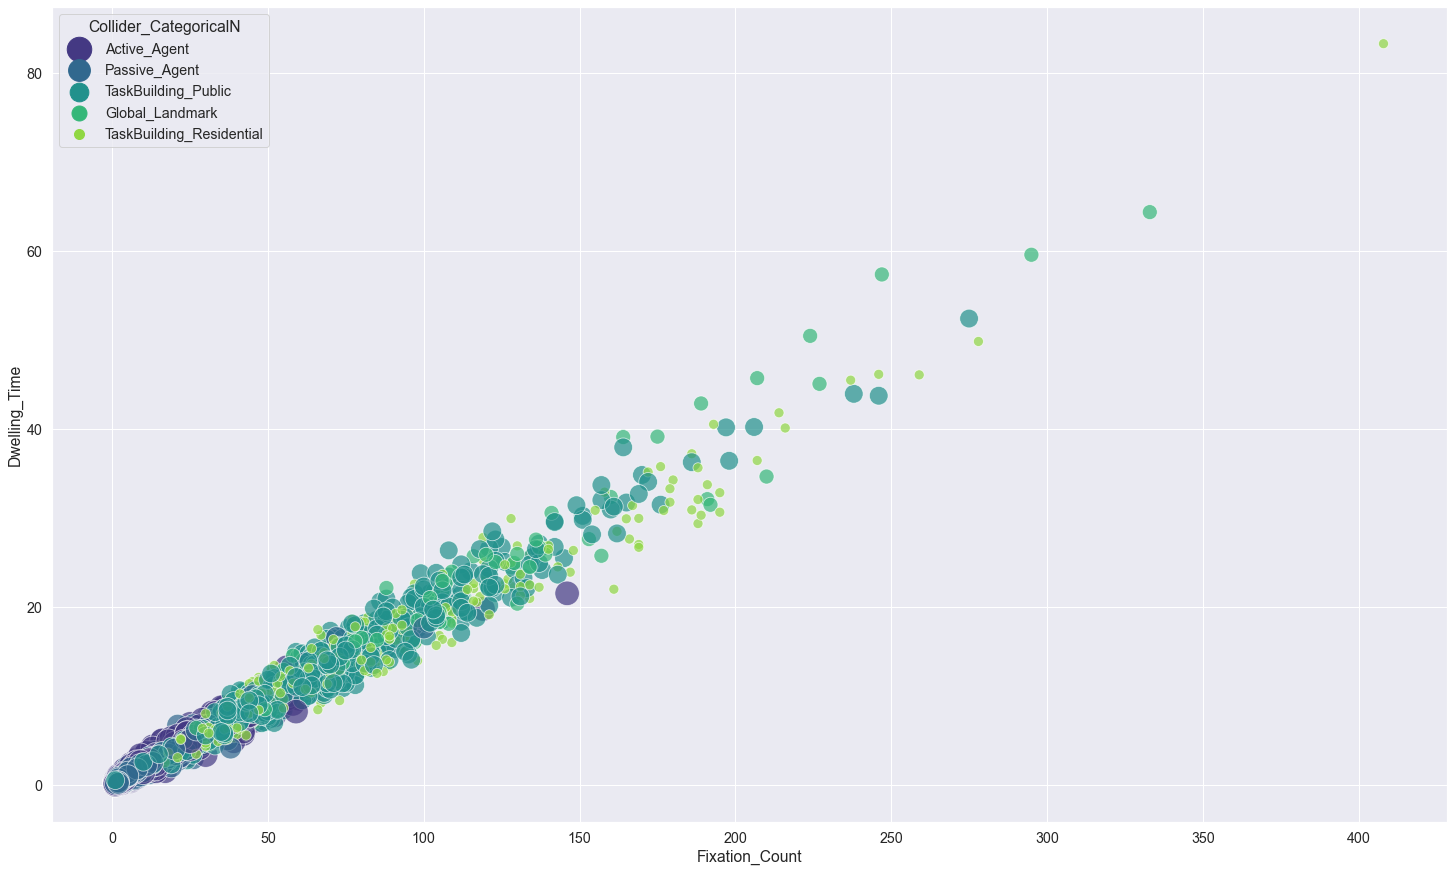

In [65]:
plt.figure(figsize=(25,15))
sns.set(font_scale = 1.3)
sns.scatterplot(x='Fixation_Count', y='Dwelling_Time', hue="Collider_CategoricalN",
                size="Collider_CategoricalN", sizes=(100,600), legend="full", data=Fixations, alpha=0.7, palette="viridis")

<Figure size 1800x1080 with 0 Axes>

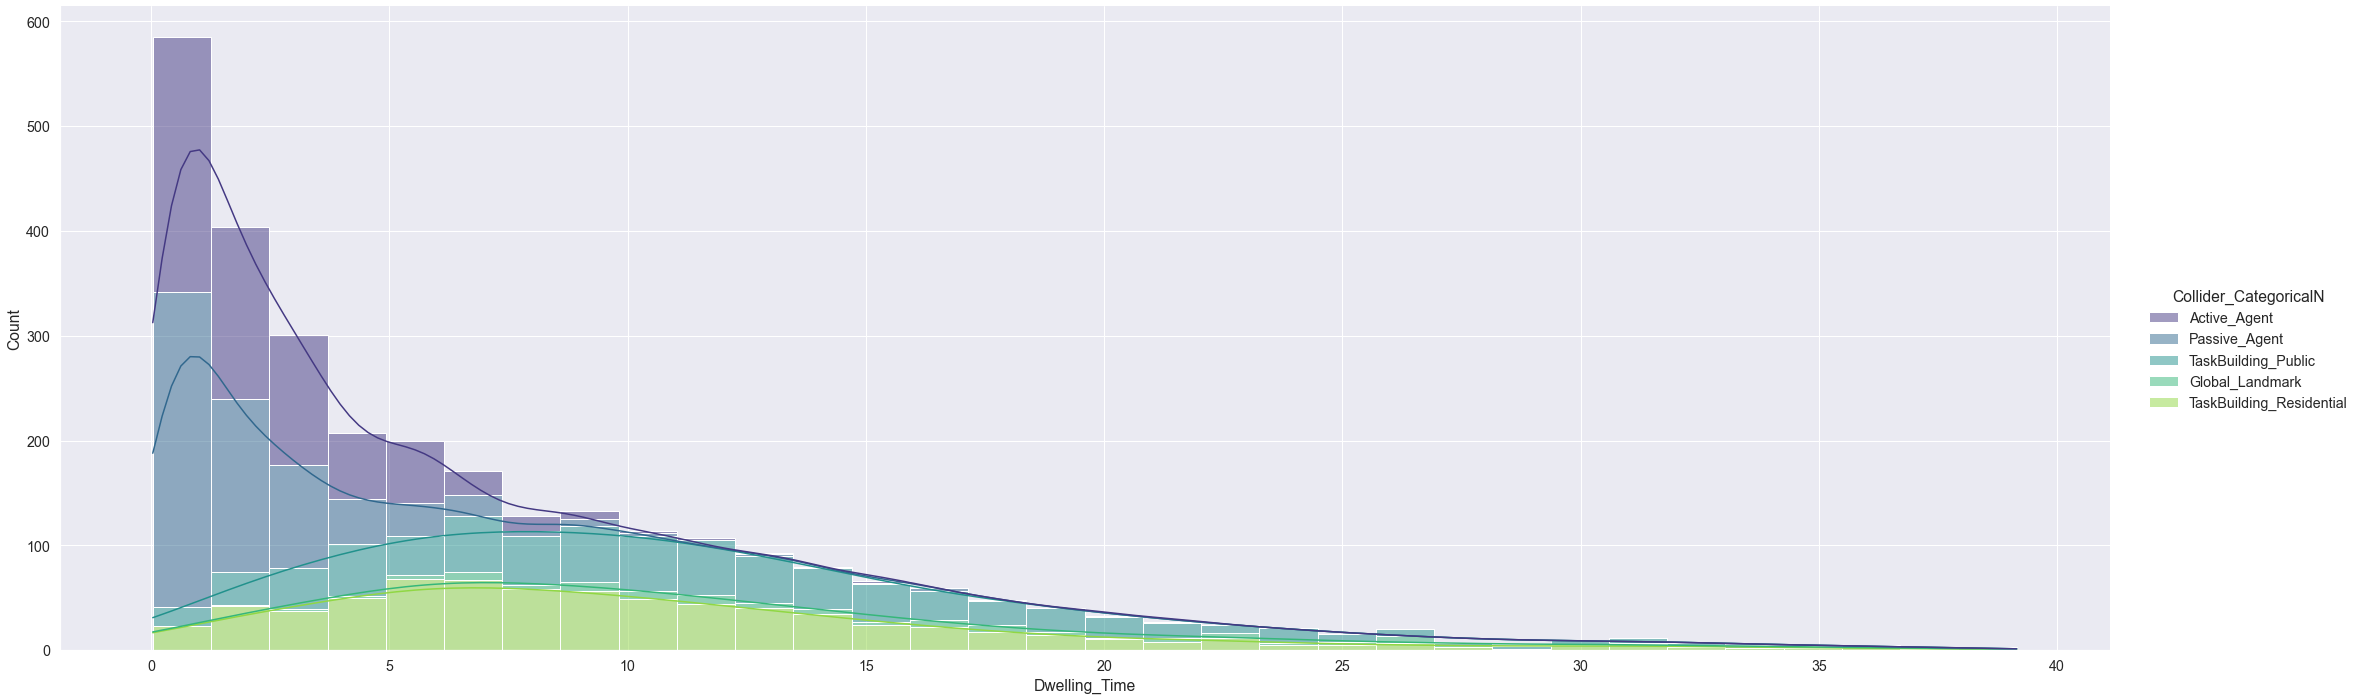

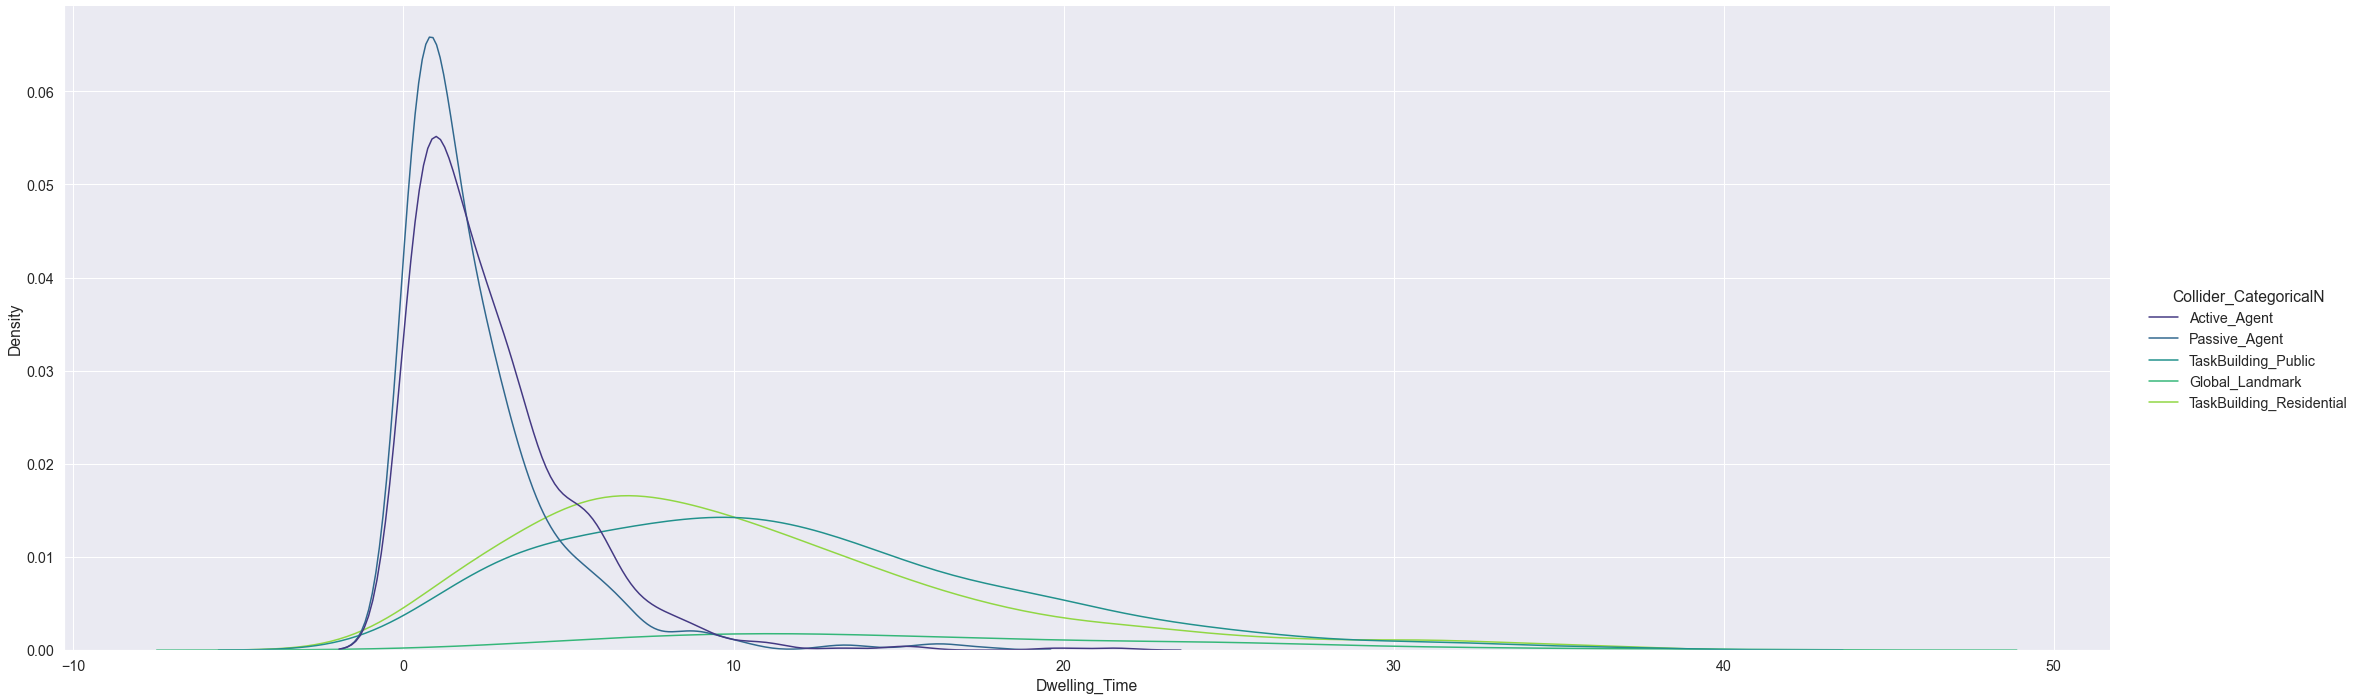

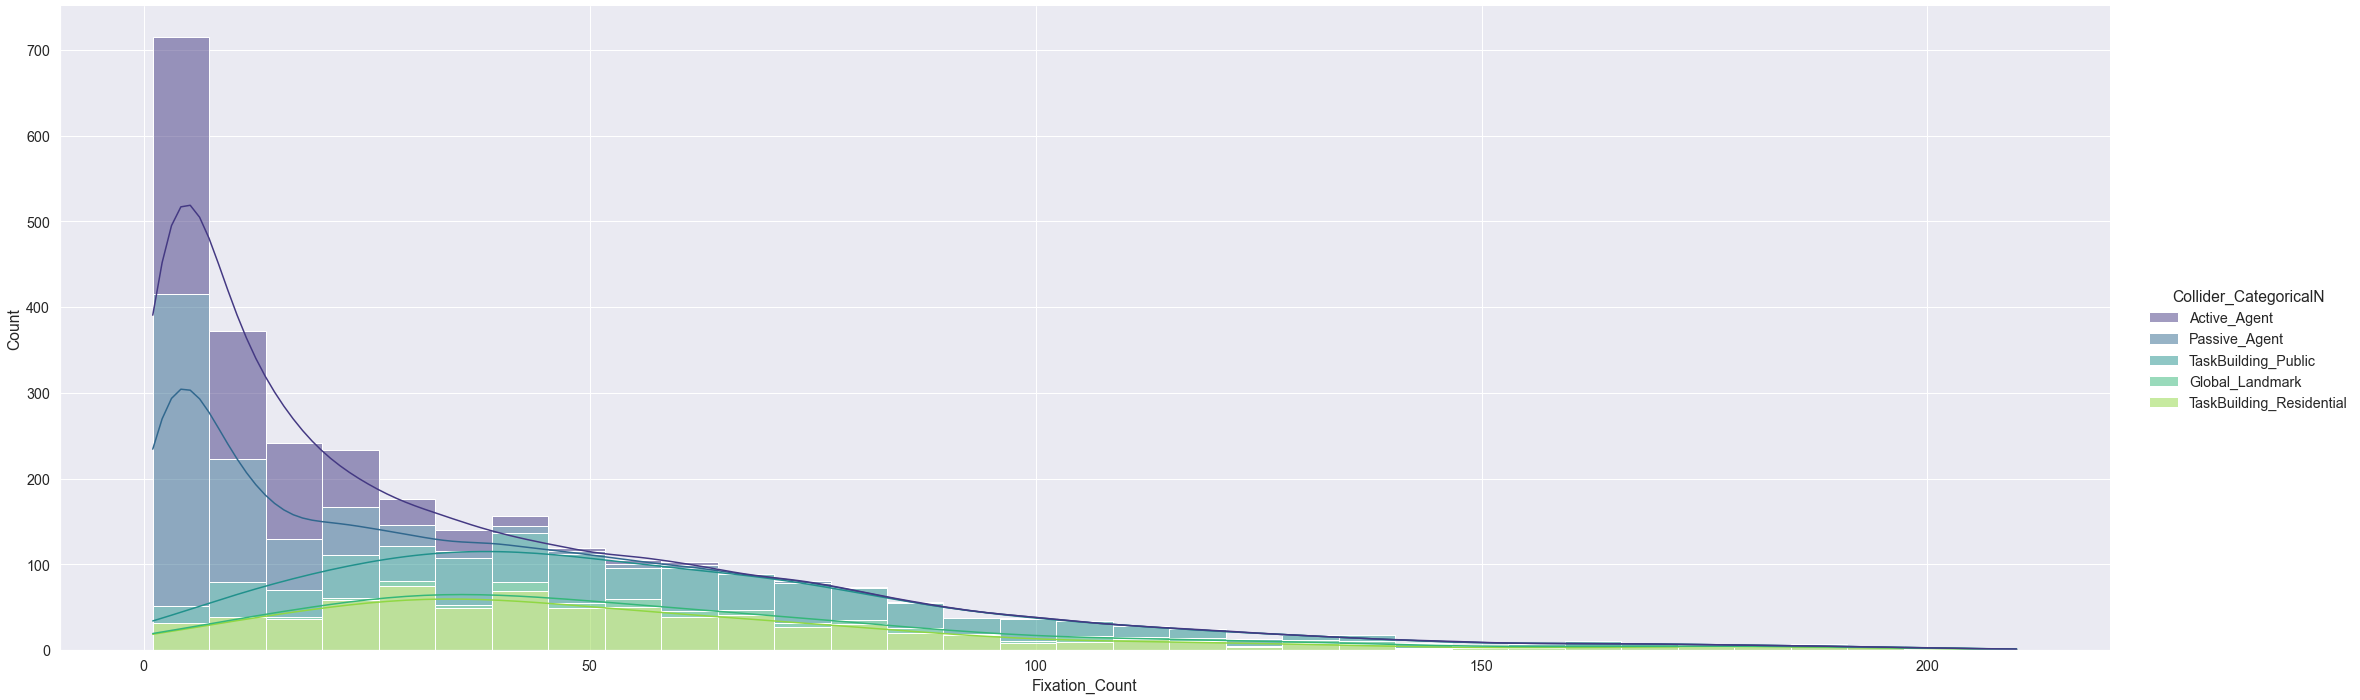

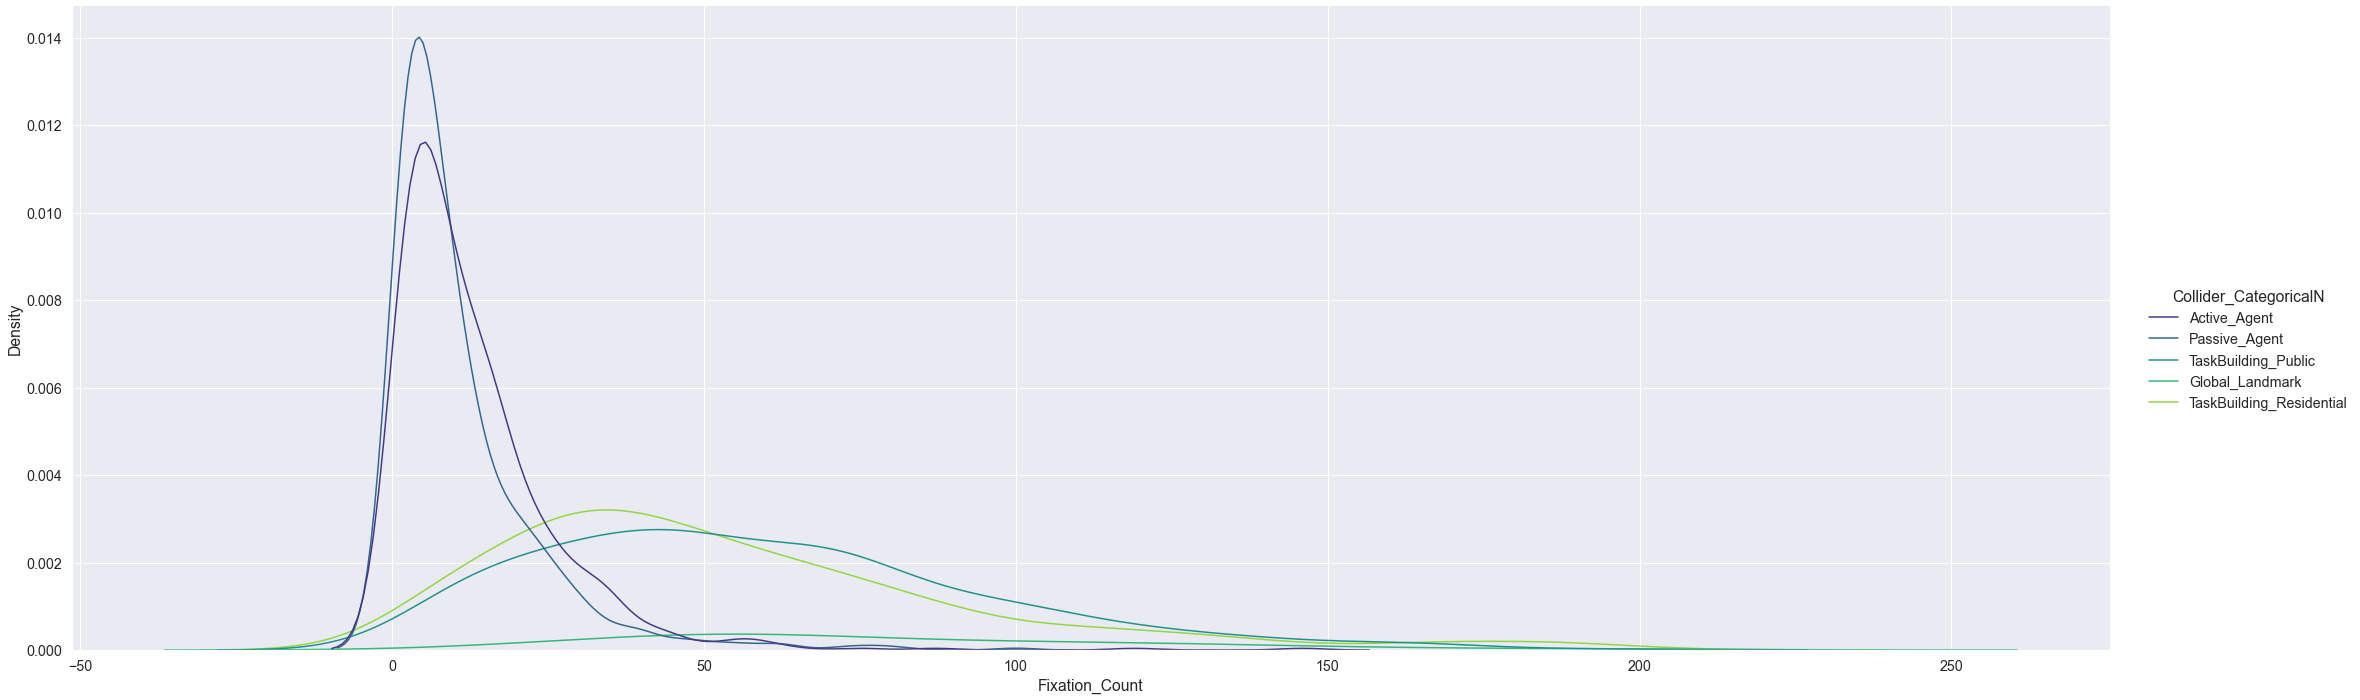

In [66]:
plt.figure(figsize=(25,15))
sns.set(font_scale = 1.3)
sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kind="kde", palette="viridis")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kind="kde", palette="viridis")

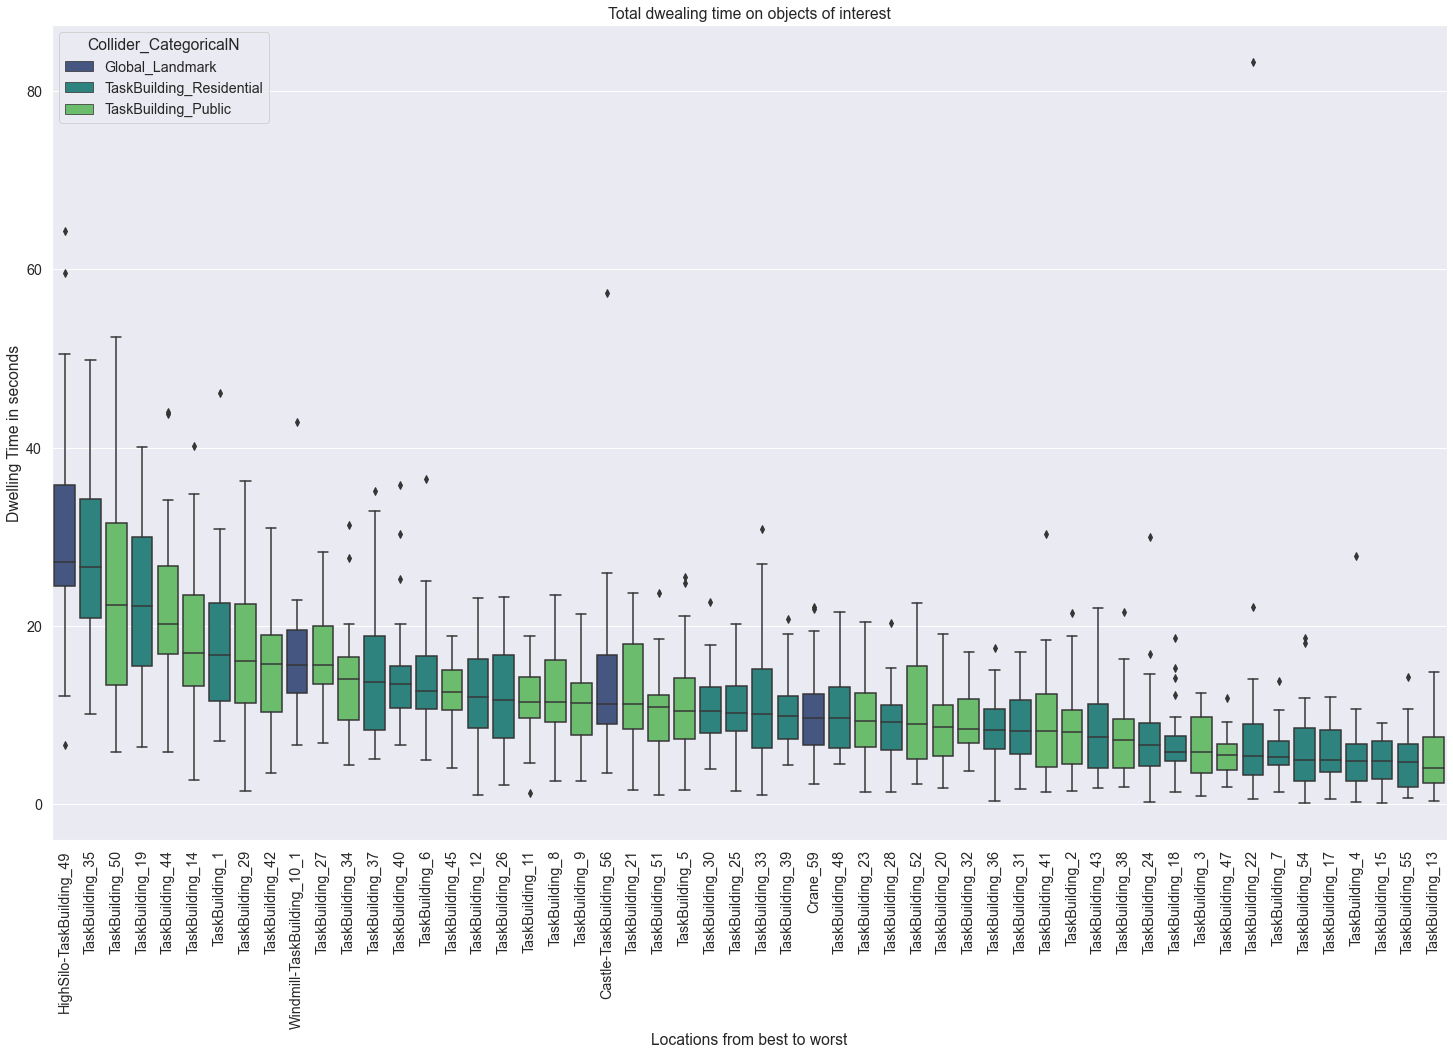

In [67]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Dwelling_Time', dodge=False, hue="Collider_CategoricalN", order= order_buildings.index.values, data=TaskBuildings_GL, palette="viridis")
plt.title('Total dwealing time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Dwelling Time in seconds')
plt.xticks(rotation=90);

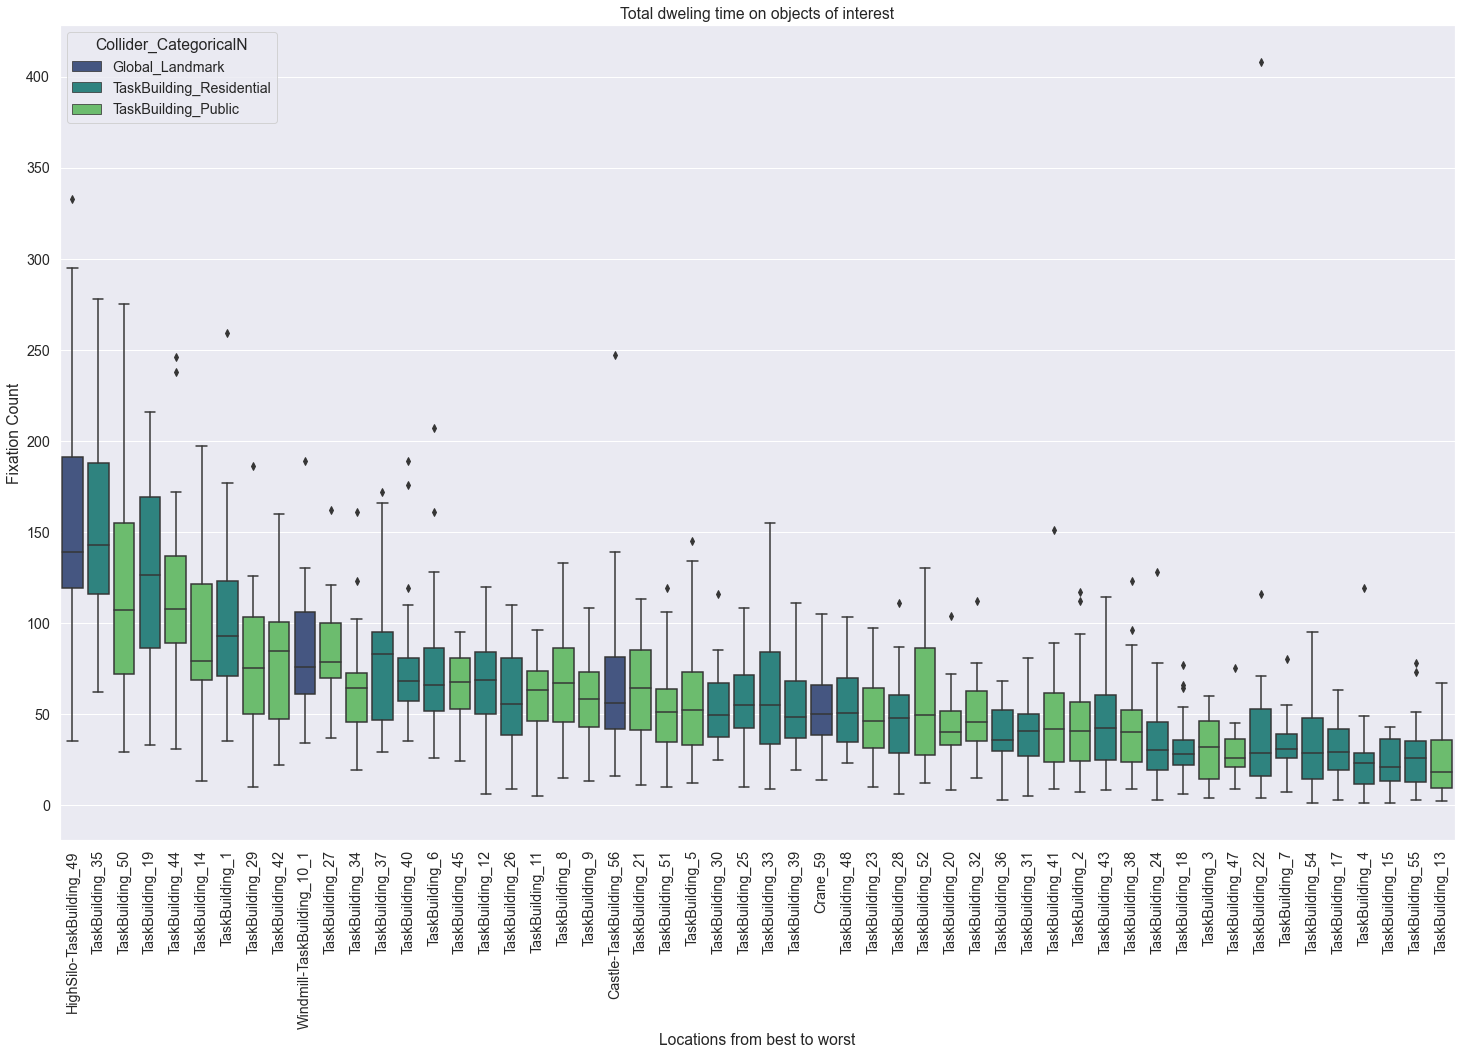

In [68]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Fixation_Count', dodge=False, hue="Collider_CategoricalN", order= order_buildings.index.values, data=TaskBuildings_GL, palette="viridis")
plt.title('Total dweling time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Fixation Count')
plt.xticks(rotation=90);

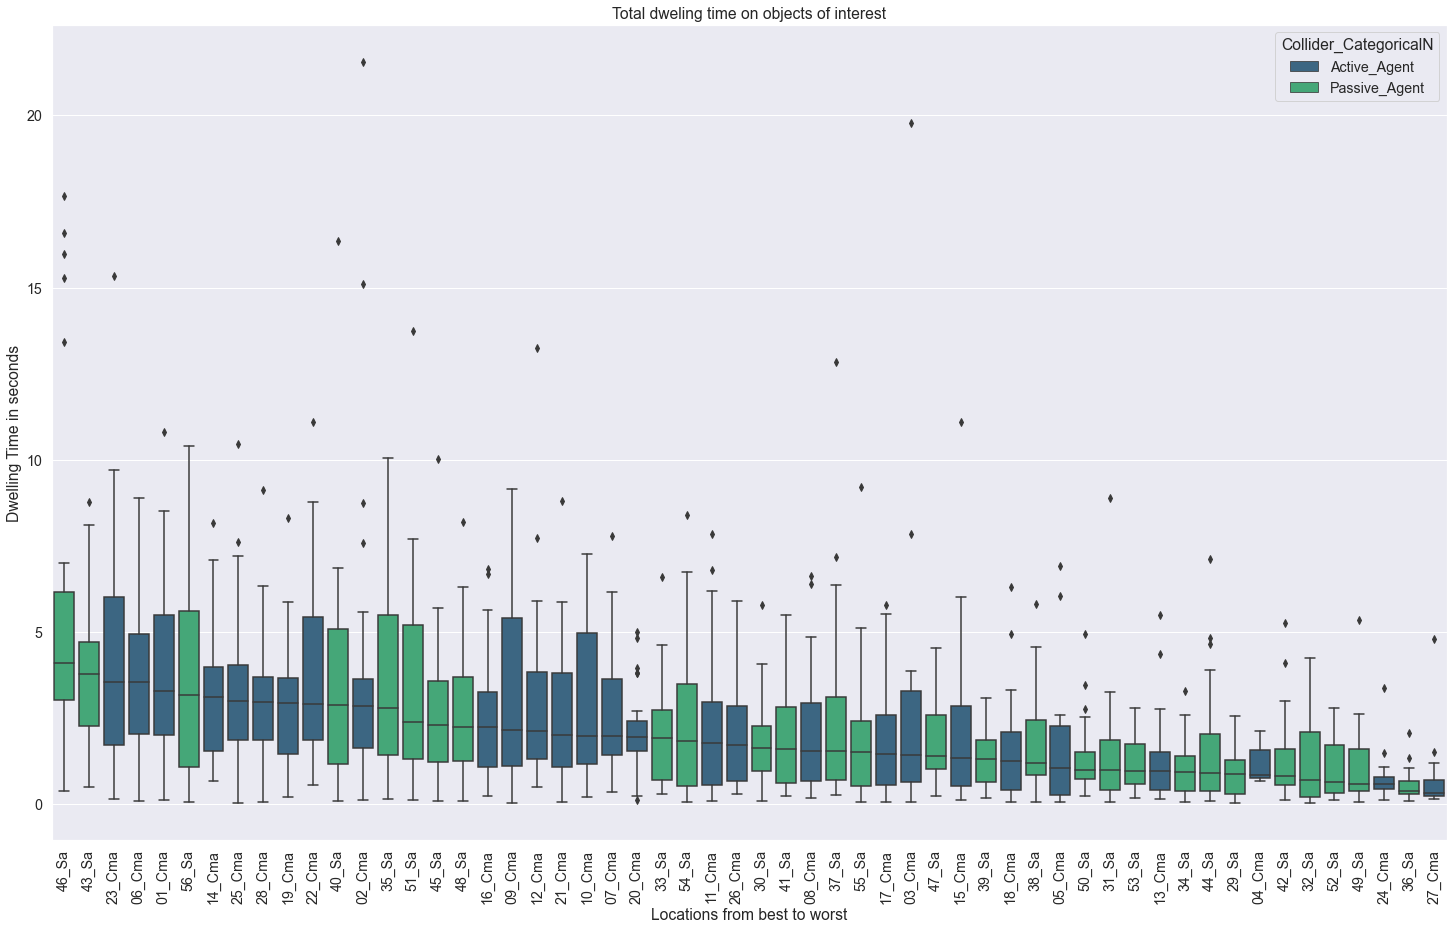

In [69]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Dwelling_Time', dodge=False, hue="Collider_CategoricalN", order= order_agents.index.values, data=Agents, palette="viridis")
plt.title('Total dweling time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Dwelling Time in seconds')
plt.xticks(rotation=90);

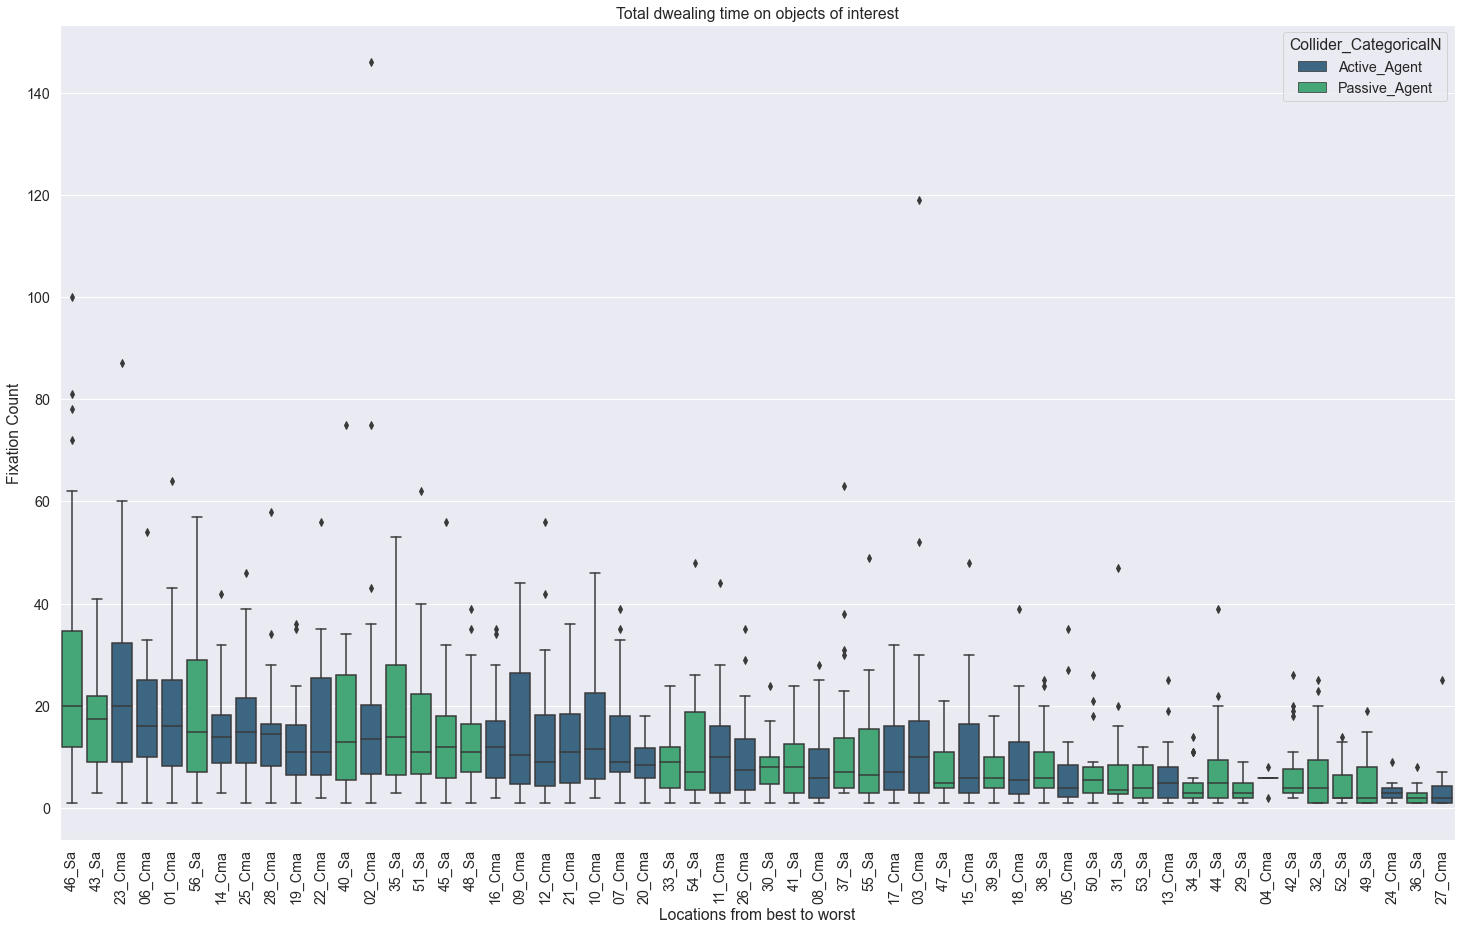

In [70]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Fixation_Count', dodge=False, hue="Collider_CategoricalN", order= order_agents.index.values, data=Agents, palette="viridis")
plt.title('Total dwealing time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Fixation Count')
plt.xticks(rotation=90);

## Preparation for the merging of behavioral data with Dwelling times 

In [71]:
# Create a dictionary that identifies: Agent, Building, and graffity with one ID
patterns1 = {'^01_Cma$':1}
patterns1.update(dict.fromkeys(['^TaskBuilding_14$','^Graffity_14$'], 1))
patterns1.update(dict.fromkeys(['^02_Cma$','^TaskBuilding_41$','^Graffity_41$'], 2))
patterns1.update(dict.fromkeys(['^03_Cma$','^TaskBuilding_2$', '^Graffity_02$'], 3))
patterns1.update(dict.fromkeys(['^04_Cma$','^TaskBuilding_47$','^Graffity_47$'], 4))
patterns1.update(dict.fromkeys(['^05_Cma$','^Construction_57$'], 5))
patterns1.update(dict.fromkeys(['^06_Cma$','^TaskBuilding_20$','^Graffity_20$'], 6))
patterns1.update(dict.fromkeys(['^07_Cma$','^TaskBuilding_9$','^Graffity_09$'], 7))
patterns1.update(dict.fromkeys(['^08_Cma$','^TaskBuilding_50$','^Graffity_50$'], 8))
patterns1.update(dict.fromkeys(['^09_Cma$','^TaskBuilding_45$','^Graffity_45$'], 9))
patterns1.update(dict.fromkeys(['^10_Cma$','^TaskBuilding_8$','^Graffity_08$'], 10))
patterns1.update(dict.fromkeys(['^11_Cma$','^TaskBuilding_27$','^Graffity_27$'], 11))
patterns1.update(dict.fromkeys(['^12_Cma$','^TaskBuilding_51$','^Graffity_51$'], 12))
patterns1.update(dict.fromkeys(['^13_Cma$','^TaskBuilding_3$','^Graffity_03$'], 13))
patterns1.update(dict.fromkeys(['^14_Cma$','^TaskBuilding_11$','^Graffity_11$'], 14))
patterns1.update(dict.fromkeys(['^15_Cma$','^TaskBuilding_42$','^Graffity_42$'], 15))
patterns1.update(dict.fromkeys(['^16_Cma$','^TaskBuilding_23$','^Graffity_23$'], 16))
patterns1.update(dict.fromkeys(['^17_Cma$','^TaskBuilding_52$','^Graffity_52$'], 17))
patterns1.update(dict.fromkeys(['^18_Cma$','^TaskBuilding_38$','^Graffity_38$'], 18))
patterns1.update(dict.fromkeys(['^19_Cma$','^TaskBuilding_34$','^Graffity_34$'], 19))
patterns1.update(dict.fromkeys(['^20_Cma$','^BasketballCourt_58$'], 20))
patterns1.update(dict.fromkeys(['^21_Cma$','^TaskBuilding_5$','^Graffity_05$'], 21))
patterns1.update(dict.fromkeys(['^22_Cma$','^TaskBuilding_29$','^Graffity_29$'], 22))
patterns1.update(dict.fromkeys(['^23_Cma$','^TaskBuilding_32$','^Graffity_32$'], 23))
patterns1.update(dict.fromkeys(['^24_Cma$','^TaskBuilding_13$','^Graffity_13$'], 24))
patterns1.update(dict.fromkeys(['^25_Cma$','^TaskBuilding_44$','^Graffity_44$'], 25))
patterns1.update(dict.fromkeys(['^26_Cma$','^TaskBuilding_21$','^Graffity_21$'], 26))
patterns1.update(dict.fromkeys(['^27_Cma$','^Crane_59$', 'Castle-TaskBuilding_56'], 27))
patterns1.update(dict.fromkeys(['^28_Cma$','^Church-TaskBuilding_16'], 28))
patterns1.update(dict.fromkeys(['^29_Sa$','^TaskBuilding_4$','^Graffity_04$'], 29))
patterns1.update(dict.fromkeys(['^30_Sa$','^TaskBuilding_1$','^Graffity_01$'], 30))
patterns1.update(dict.fromkeys(['^31_Sa$','^TaskBuilding_6$','^Graffity_06$'], 31))
patterns1.update(dict.fromkeys(['^32_Sa$','^TaskBuilding_7$','^Graffity_07$'], 32))
patterns1.update(dict.fromkeys(['^33_Sa$','^TaskBuilding_17$','^Graffity_17$'], 33))
patterns1.update(dict.fromkeys(['^34_Sa$','^TaskBuilding_15$','^Graffity_15$'], 34))
patterns1.update(dict.fromkeys(['^35_Sa$','^TaskBuilding_12$','^Graffity_12$'], 35))
patterns1.update(dict.fromkeys(['^36_Sa$','^TaskBuilding_18$','^Graffity_18$'], 36))
patterns1.update(dict.fromkeys(['^37_Sa$','^TaskBuilding_19$','^Graffity_19$'], 37))
patterns1.update(dict.fromkeys(['^38_Sa$','^TaskBuilding_22$','^Graffity_22$'], 38))
patterns1.update(dict.fromkeys(['^39_Sa$','^TaskBuilding_24$','^Graffity_24$'], 39))
patterns1.update(dict.fromkeys(['^40_Sa','^TaskBuilding_25$','^Graffity_25$'], 40))
patterns1.update(dict.fromkeys(['^41_Sa','^TaskBuilding_26$','^Graffity_26$'], 41))
patterns1.update(dict.fromkeys(['^42_Sa','^TaskBuilding_28$','^Graffity_28$'], 42))
patterns1.update(dict.fromkeys(['^43_Sa','^TaskBuilding_30$','^Graffity_30$'], 43))
patterns1.update(dict.fromkeys(['^44_Sa','^TaskBuilding_31$','^Graffity_31$'], 44))
patterns1.update(dict.fromkeys(['^45_Sa','^TaskBuilding_33$','^Graffity_33$'], 45))
patterns1.update(dict.fromkeys(['^46_Sa','^TaskBuilding_35$','^Graffity_35$'], 46))
patterns1.update(dict.fromkeys(['^47_Sa','^TaskBuilding_36$','^Graffity_36$'], 47))
patterns1.update(dict.fromkeys(['^48_Sa','^TaskBuilding_37$','^Graffity_37$'], 48))
patterns1.update(dict.fromkeys(['^49_Sa','^TaskBuilding_39$','^Graffity_39$'], 49))
patterns1.update(dict.fromkeys(['^50_Sa','^TaskBuilding_40$','^Graffity_40$'], 50))
patterns1.update(dict.fromkeys(['^51_Sa','^TaskBuilding_43$','^Graffity_43$'], 51))
patterns1.update(dict.fromkeys(['^52_Sa','^TaskBuilding_48$','^Graffity_48$'], 52))
patterns1.update(dict.fromkeys(['^53_Sa','^TaskBuilding_54$','^Graffity_54$'], 53))
patterns1.update(dict.fromkeys(['^54_Sa','^TaskBuilding_55$','^Graffity_55$'], 54))
patterns1.update(dict.fromkeys(['^55_Sa','^Windmill-TaskBuilding_10_1'], 55))
patterns1.update(dict.fromkeys(['^56_Sa','^HighSilo-TaskBuilding_49'], 56))
default_val = np.nan

In [82]:
Fixations['avatar_ID'] = Fixations['recoded'].apply(lambda x: next((val for key, val in patterns1.items() if re.match(key, x)), default_val))    

In [83]:
Fixations['Category'] = np.where(Fixations.Collider_CategoricalN.str.contains("Agent"), "Agent_Gaze", "Building_Gaze")

In [84]:
Agent_Fixation = Fixations[Fixations.Category == "Agent_Gaze"]
Building_Fixation = Fixations[Fixations.Category == "Building_Gaze"]
Building_Fixation = Building_Fixation[Building_Fixation.recoded != 'Crane_59'].copy()

In [76]:
Fixations

SubjectID                     recoded     Collider_CategoricalN  \
0           365                      01_Cma              Active_Agent   
1           365                      02_Cma              Active_Agent   
2           365                      05_Cma              Active_Agent   
3           365                      06_Cma              Active_Agent   
4           365                      07_Cma              Active_Agent   
...         ...                         ...                       ...   
2947       9601              TaskBuilding_6  TaskBuilding_Residential   
2948       9601              TaskBuilding_7  TaskBuilding_Residential   
2949       9601              TaskBuilding_8       TaskBuilding_Public   
2950       9601              TaskBuilding_9       TaskBuilding_Public   
2951       9601  Windmill-TaskBuilding_10_1           Global_Landmark   

      Dwelling_Time  Fixation_Count  Avatar_ID       Category  
0          0.999441               5          1     Agent_Gaze  
1          2.241917               8          2     Agent_Gaze  
2          0.255441               2          5     Agent_Gaze  
3          4.235831              19          6     Agent_Gaze  
4          1.380368               6          7     Agent_Gaze  
...             ...             ...        ...            ...  
2947      19.694432              93         31  Building_Gaze  
2948       5.850799              31         32  Building_Gaze  
2949       9.518699              44         10  Building_Gaze  
2950       8.078908              44          7  Building_Gaze  
2951      22.945343             106         55  Building_Gaze  

[2952 rows x 7 columns]

In [86]:
Agent_wide_Fixations = Agent_Fixation.pivot(index=["SubjectID", 'avatar_ID'], columns='Category', values=["Dwelling_Time", "Fixation_Count"])
Building_wide_Fixations = Building_Fixation.pivot(index=["SubjectID", 'avatar_ID'], columns='Category', values=["Dwelling_Time", "Fixation_Count"])
Agent_wide_Fixations.reset_index(inplace=True)
Building_wide_Fixations.reset_index(inplace=True)

In [87]:
Agent_wide_Fixations.columns = ['_'.join(col) for col in Agent_wide_Fixations.columns]
Building_wide_Fixations.columns = ['_'.join(col) for col in Building_wide_Fixations.columns]
Agent_wide_Fixations

SubjectID_  avatar_ID_  Dwelling_Time_Agent_Gaze  \
0            365           1                  0.999441   
1            365           2                  2.241917   
2            365           5                  0.255441   
3            365           6                  4.235831   
4            365           7                  1.380368   
...          ...         ...                       ...   
1385        9601          51                  6.200965   
1386        9601          52                  1.078302   
1387        9601          53                  0.376387   
1388        9601          54                  0.388366   
1389        9601          55                  0.223199   

      Fixation_Count_Agent_Gaze  
0                           5.0  
1                           8.0  
2                           2.0  
3                          19.0  
4                           6.0  
...                         ...  
1385                       27.0  
1386                        5.0  
1387                        2.0  
1388                        2.0  
1389                        2.0  

[1390 rows x 4 columns]

In [88]:
Agent_wide_Fixations.rename({"SubjectID_":"SubjectID", "avatar_ID_":"avatar_ID"}, inplace=True, axis=1)
Building_wide_Fixations.rename({"SubjectID_":"SubjectID", "avatar_ID_":"avatar_ID"}, inplace=True, axis=1)

In [89]:
wide_Fixations = Building_wide_Fixations.merge(Agent_wide_Fixations, on=["SubjectID", "avatar_ID"])
wide_Fixations

SubjectID  avatar_ID  Dwelling_Time_Building_Gaze  \
0           365          1                    12.048333   
1           365          2                     4.683234   
2           365          5                     0.424187   
3           365          6                    11.538924   
4           365          7                     8.279220   
...         ...        ...                          ...   
1358       9601         51                    21.986085   
1359       9601         52                    10.778504   
1360       9601         53                     6.379526   
1361       9601         54                     5.136893   
1362       9601         55                    22.945343   

      Fixation_Count_Building_Gaze  Dwelling_Time_Agent_Gaze  \
0                             60.0                  0.999441   
1                             20.0                  2.241917   
2                              1.0                  0.255441   
3                             54.0                  4.235831   
4                             38.0                  1.380368   
...                            ...                       ...   
1358                         114.0                  6.200965   
1359                          62.0                  1.078302   
1360                          29.0                  0.376387   
1361                          22.0                  0.388366   
1362                         106.0                  0.223199   

      Fixation_Count_Agent_Gaze  
0                           5.0  
1                           8.0  
2                           2.0  
3                          19.0  
4                           6.0  
...                         ...  
1358                       27.0  
1359                        5.0  
1360                        2.0  
1361                        2.0  
1362                        2.0  

[1363 rows x 6 columns]

<Figure size 1800x1080 with 0 Axes>

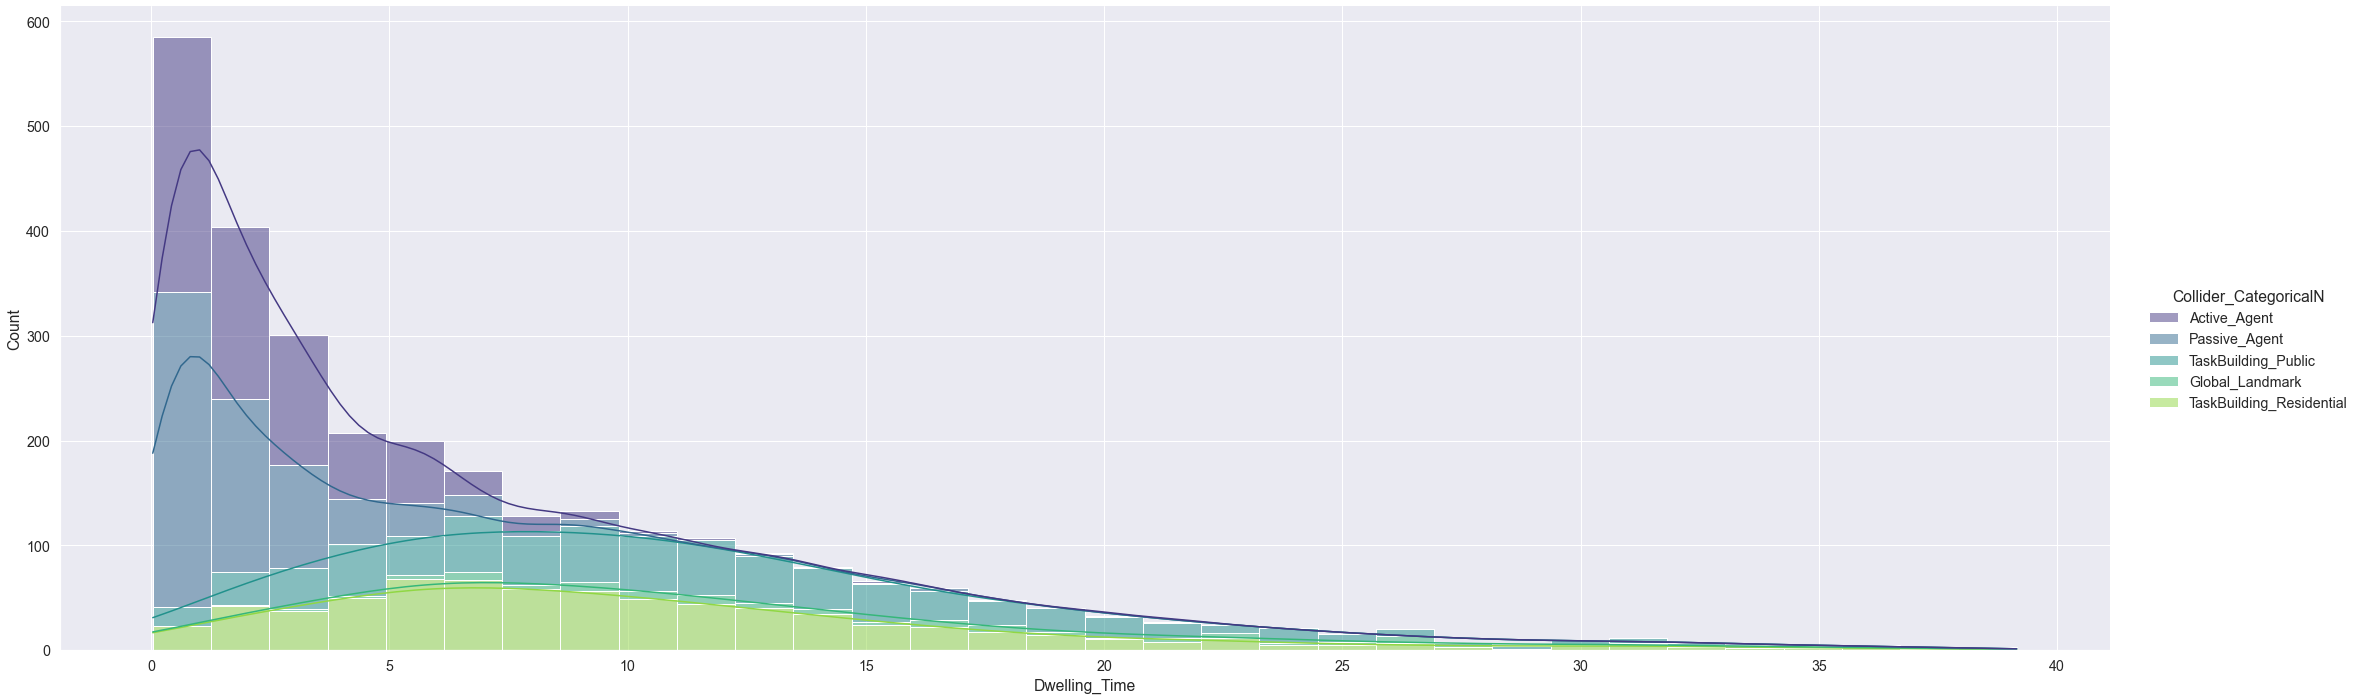

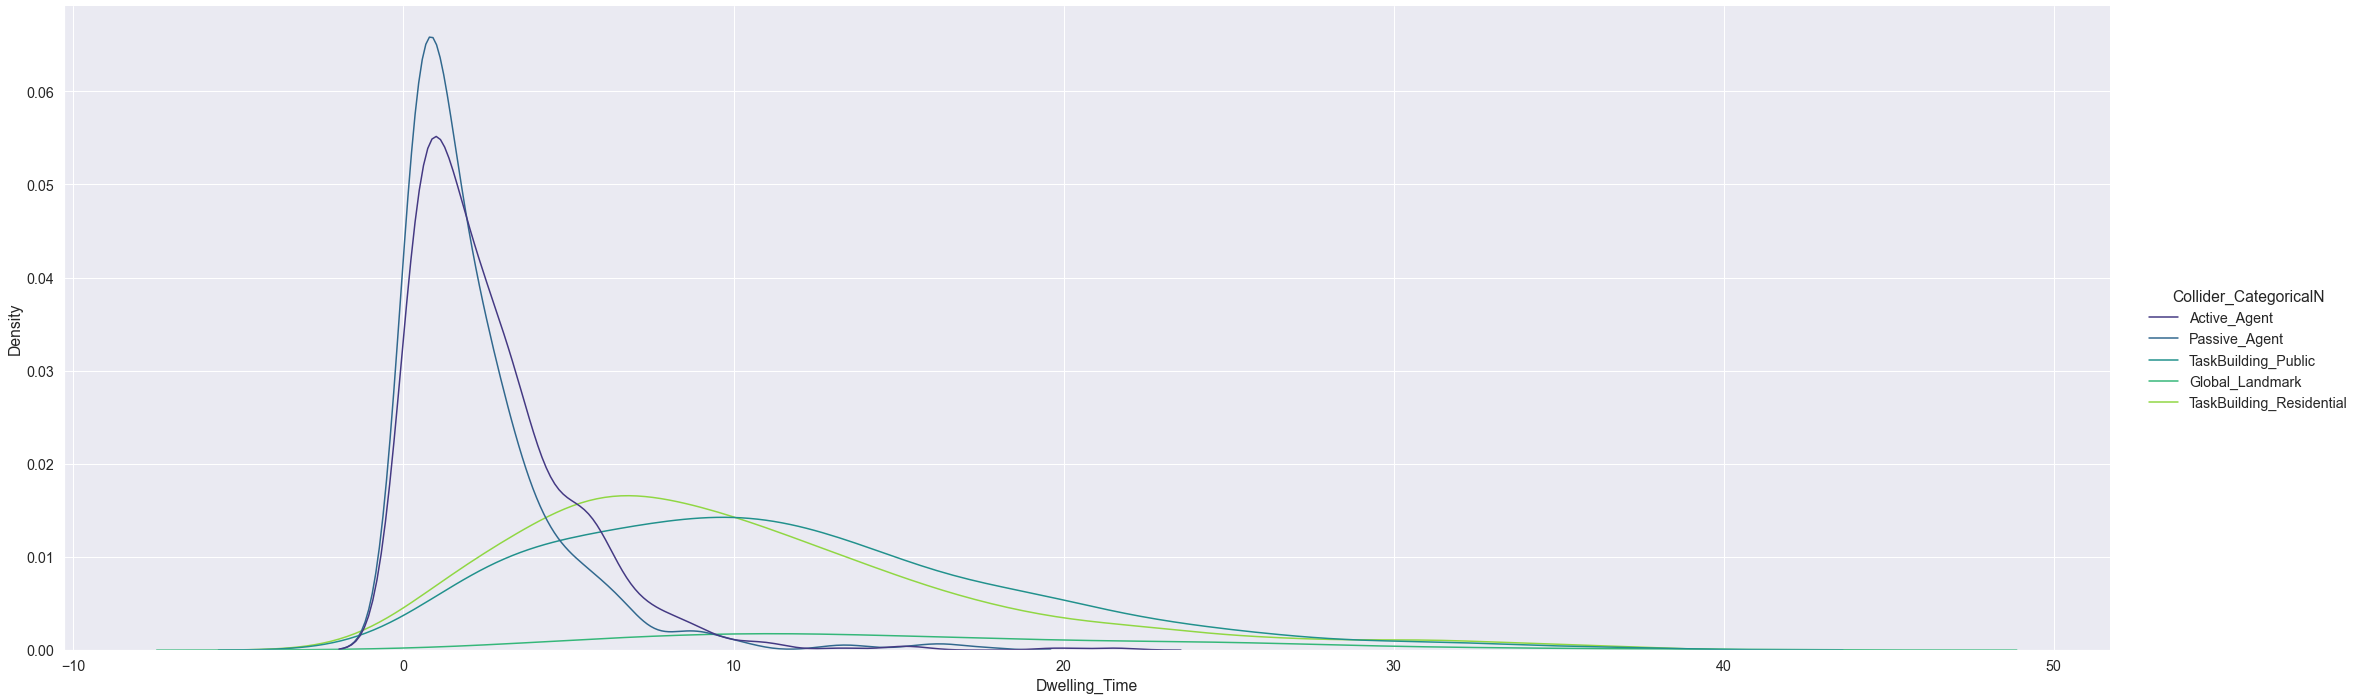

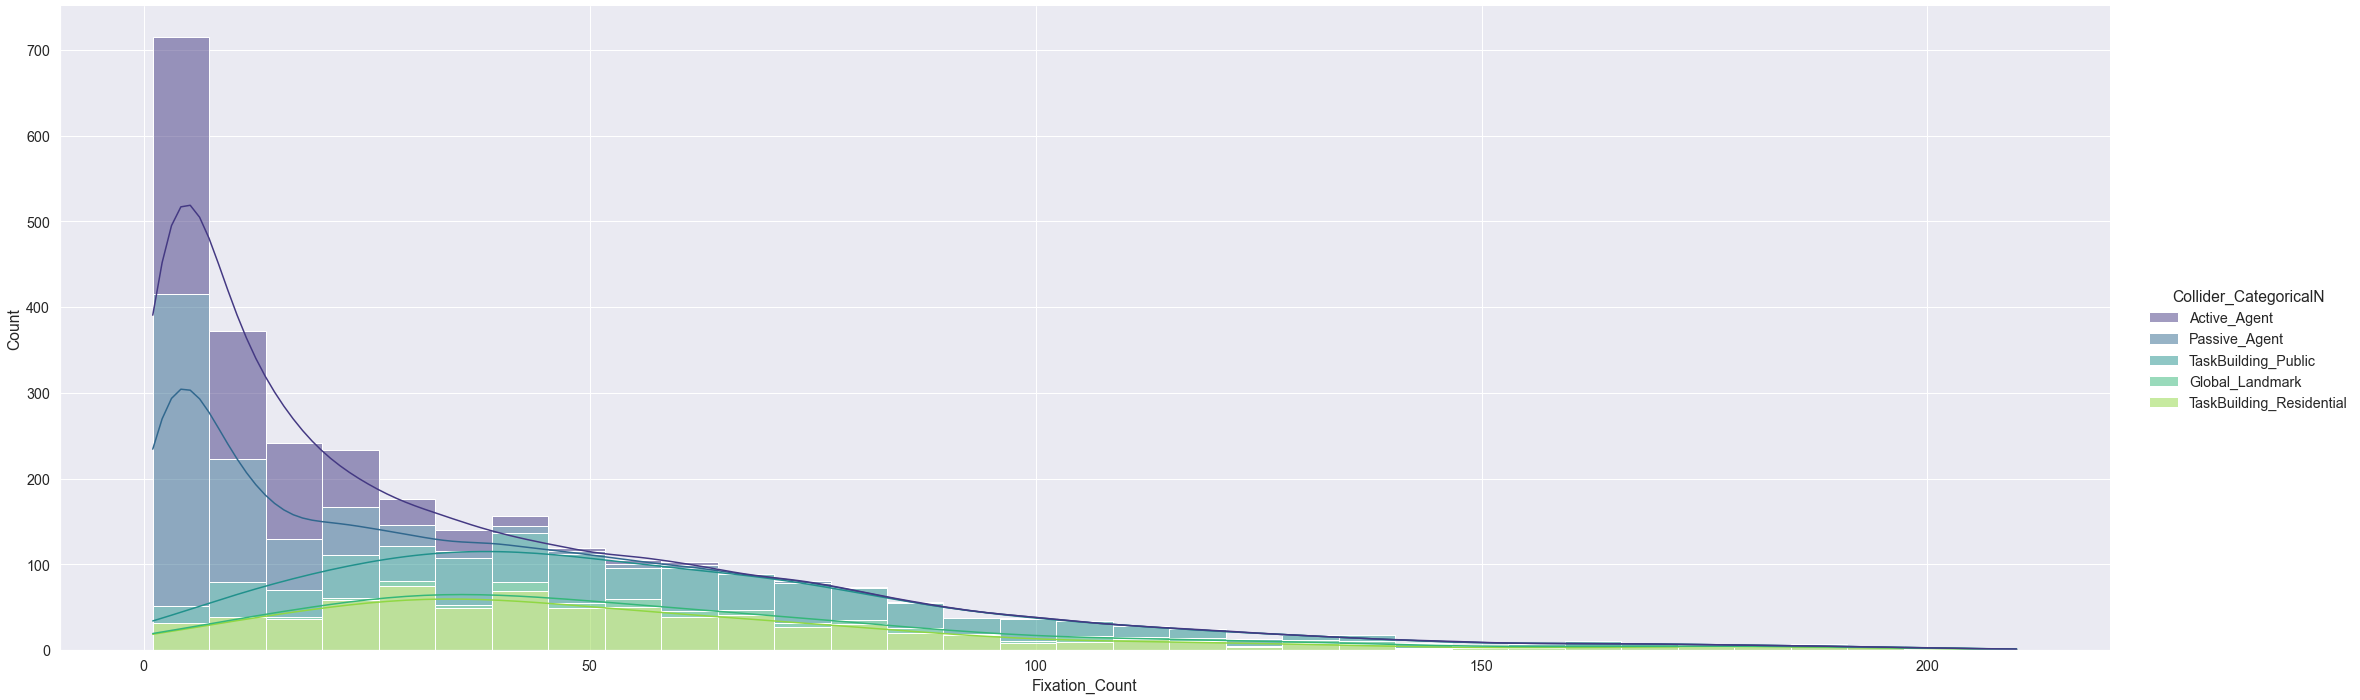

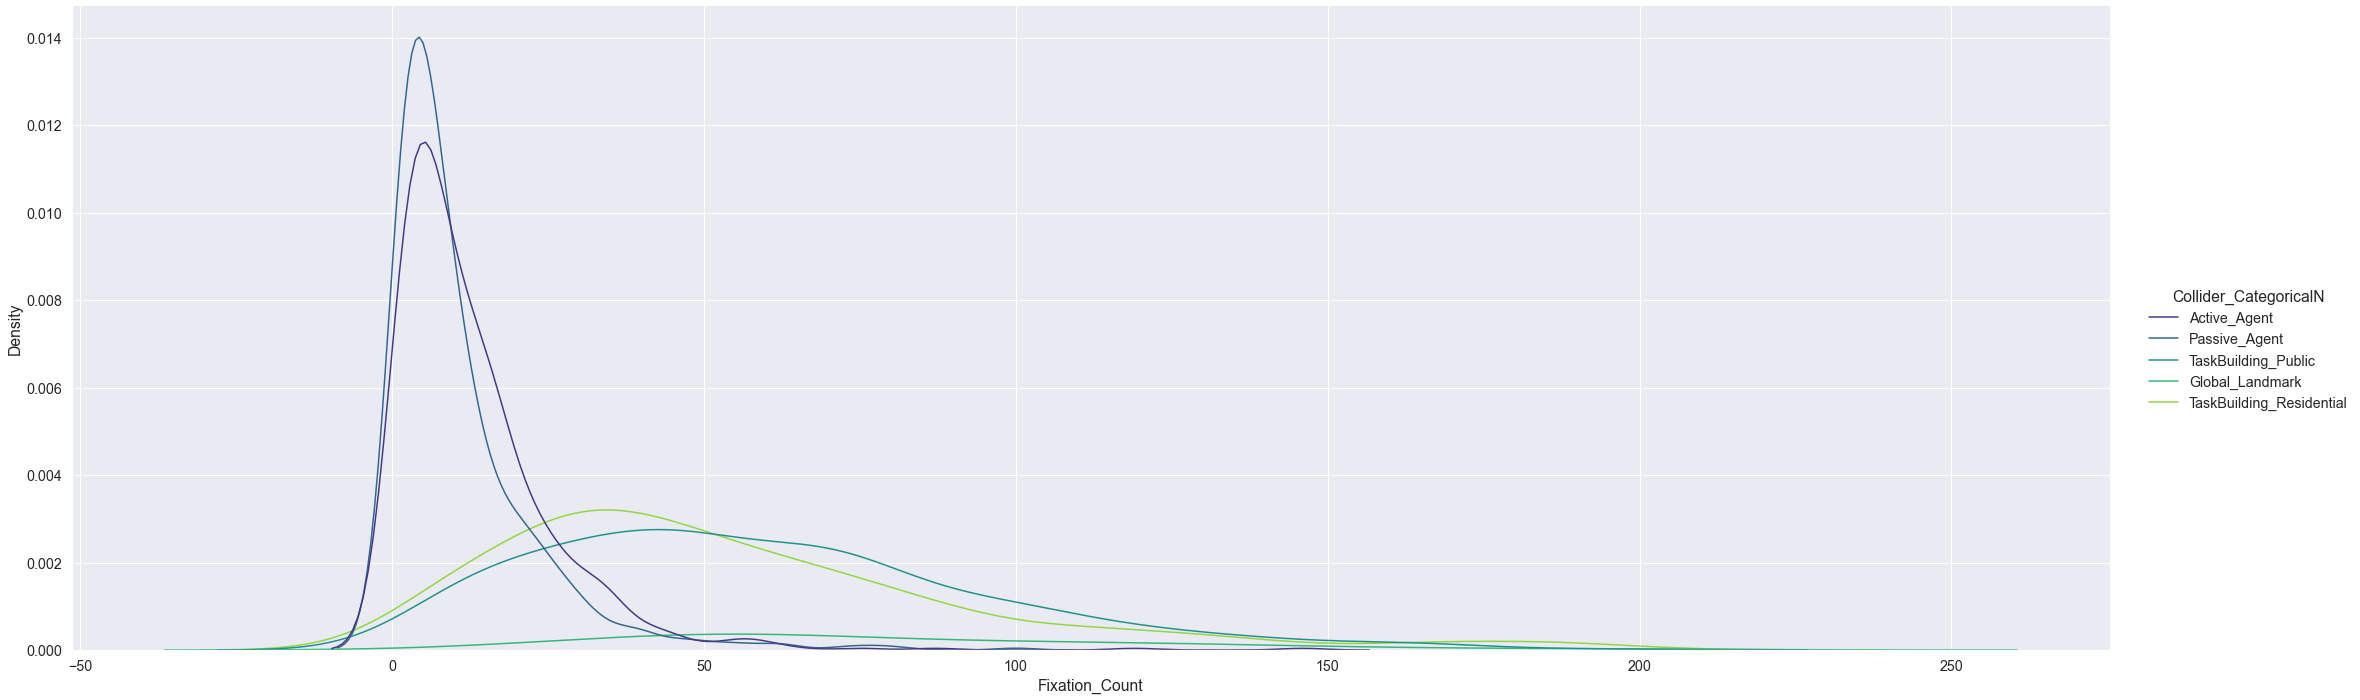

In [90]:
plt.figure(figsize=(25,15))
sns.set(font_scale = 1.3)
sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kind="kde", palette="viridis")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kde=True, palette="viridis",  multiple="stack")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations[Fixations.Dwelling_Time < 40], 
            height=10, aspect= 3, kind="kde", palette="viridis")

In [92]:
Behavioral = pd.read_csv("/Volumes/TwoTeras/0_Experiment_1/Pointing_Task/Results/PointingSummary_1_exp1.csv")

In [93]:
Behavioral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10048 entries, 0 to 10047
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     10048 non-null  int64  
 1   ID                             10048 non-null  int64  
 2   AbsolutError                   10048 non-null  float64
 3   SignedAngle-+180               10048 non-null  float64
 4   IQR                            10048 non-null  float64
 5   RT                             10048 non-null  float64
 6   DistanceToParticipant          10048 non-null  float64
 7   PointingTaskStartingLocations  10048 non-null  int64  
 8   TrialNumber                    10048 non-null  int64  
 9   StartPointID                   10048 non-null  int64  
 10  ID_for_StartingPosition        10048 non-null  int64  
 11  avatarID                       10048 non-null  int64  
 12  AvatarPresenceCategory         10048 non-null 

In [94]:
Behavioral.rename({"ID":"SubjectID", "avatarID":"avatar_ID"}, axis=1, inplace=True)
Behavioral

Unnamed: 0  SubjectID  AbsolutError  SignedAngle-+180        IQR  \
0               0        365     15.396716         15.396716  63.921884   
1               1        365      6.037733         -6.037733  63.921884   
2               2        365      6.345290          6.345290  63.921884   
3               3        365      3.627752          3.627752  63.921884   
4               4        365     19.115237        -19.115237  63.921884   
...           ...        ...           ...               ...        ...   
10043       10043       9601     74.369573        -74.369573  48.844684   
10044       10044       9601    102.487607       -102.487607  48.844684   
10045       10045       9601     42.251951         42.251951  48.844684   
10046       10046       9601     40.642620         40.642620  48.844684   
10047       10047       9601    161.998728        161.998728  48.844684   

              RT  DistanceToParticipant  PointingTaskStartingLocations  \
0      25.825715             197.768723                             21   
1       4.799789             213.475525                             16   
2       4.638590             111.623512                             13   
3       2.361455             111.623512                             13   
4       5.975304             232.765823                              8   
...          ...                    ...                            ...   
10043  13.249648             271.054443                              4   
10044  13.332483             514.466797                             10   
10045   3.400082             706.590820                              5   
10046   2.924416             706.590820                              5   
10047   9.175007             302.927002                             21   

       TrialNumber  StartPointID  ID_for_StartingPosition  avatar_ID  \
0                1             1                        1         46   
1               78             7                        6         46   
2               88             8                        4         46   
3               95             8                       11         46   
4              131            11                       11         46   
...            ...           ...                      ...        ...   
10043           50             5                        2         53   
10044          115            10                        7         53   
10045          292            25                        4         53   
10046          297            25                        9         53   
10047          304            26                        4         53   

      AvatarPresenceCategory  Context meaningfulBuilding ImageName  
0                    Present    False     Not meaningful     46_Sa  
1                    Omitted    False     Not meaningful   46_SaNo  
2                    Present    False     Not meaningful     46_Sa  
3                    Omitted    False     Not meaningful   46_SaNo  
4                    Omitted    False     Not meaningful   46_SaNo  
...                      ...      ...                ...       ...  
10043                Omitted    False     Not meaningful   53_SaNo  
10044                Present    False     Not meaningful     53_Sa  
10045                Omitted    False     Not meaningful   53_SaNo  
10046                Present    False     Not meaningful     53_Sa  
10047                Present    False     Not meaningful     53_Sa  

[10048 rows x 16 columns]

In [96]:
BehavioralData_Fixations_Wide = Behavioral.merge(wide_Fixations, on=["SubjectID", "avatar_ID"], how="left")
BehavioralData_Fixations_Wide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10048 entries, 0 to 10047
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     10048 non-null  int64  
 1   SubjectID                      10048 non-null  int64  
 2   AbsolutError                   10048 non-null  float64
 3   SignedAngle-+180               10048 non-null  float64
 4   IQR                            10048 non-null  float64
 5   RT                             10048 non-null  float64
 6   DistanceToParticipant          10048 non-null  float64
 7   PointingTaskStartingLocations  10048 non-null  int64  
 8   TrialNumber                    10048 non-null  int64  
 9   StartPointID                   10048 non-null  int64  
 10  ID_for_StartingPosition        10048 non-null  int64  
 11  avatar_ID                      10048 non-null  int64  
 12  AvatarPresenceCategory         10048 non-null 

In [97]:
BehavioralData_Fixations["Agent_Action_level"] = np.where(BehavioralData_Fixations.avatar_ID > 28, "Passive", "Active")
BehavioralData_Fixations_Wide["Agent_Action_level"] = np.where(BehavioralData_Fixations_Wide.avatar_ID > 28, "Passive", "Active")

In [98]:
BehavioralData_Fixations_Wide.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/BehavioralData_Fixations_Wide.csv")

In [99]:
BehavioralData_Fixations_Wide[['Dwelling_Time_Agent_Gaze', 'Dwelling_Time_Building_Gaze',
       'Fixation_Count_Agent_Gaze', 'Fixation_Count_Building_Gaze',  'AbsolutError' ]].corr().style.background_gradient(cmap="viridis")

<AxesSubplot: xlabel='AbsolutError', ylabel='Dwelling_Time'>

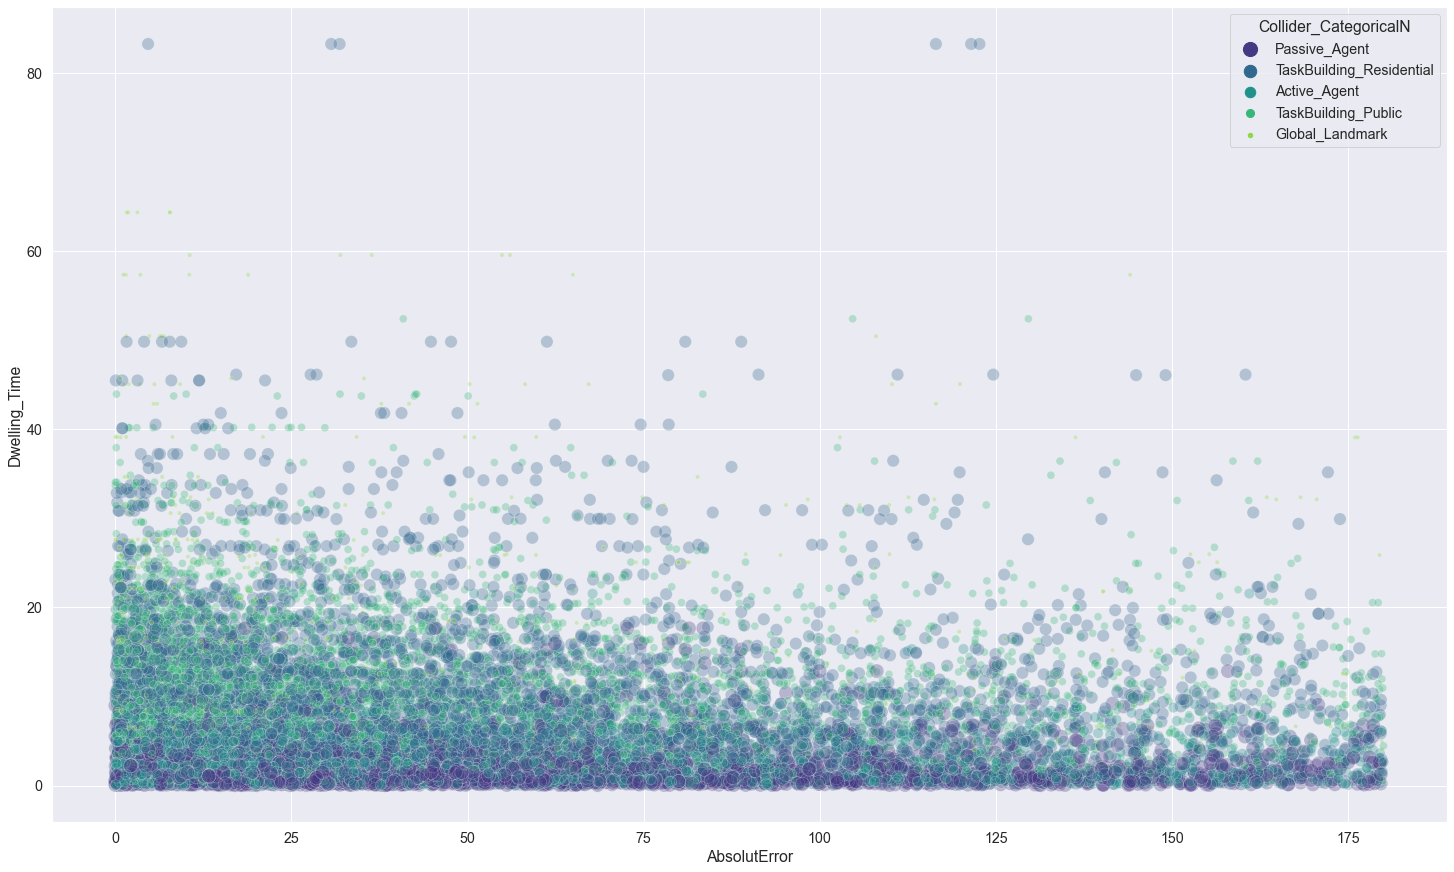

In [100]:
plt.figure(figsize=(25,15))
sns.scatterplot(x='AbsolutError', y='Dwelling_Time', hue="Collider_CategoricalN",
                size="Collider_CategoricalN", sizes=(20,200), legend="full", data=BehavioralData_Fixations, alpha=0.3, palette="viridis")

In [28]:
data_frame_gaze_no_out_ONLY_TEST.groupby([ "Hit_Object_Category", "Session"])["length"].agg(['median','count','mean','std','max', 'min'])

median  count      mean       std       max  \
Hit_Object_Category Session                                                  
Agent               1        0.170295   3579  0.208839  0.138466  0.592720   
                    2        0.174841   2722  0.206790  0.138640  0.592324   
                    3        0.188478   1979  0.219317  0.141805  0.589743   
                    4        0.177570   2013  0.213261  0.138000  0.590736   
                    5        0.166162   1935  0.202932  0.138659  0.592229   
Building            1        0.155246  11663  0.186866  0.127171  0.592720   
                    2        0.155744  10681  0.189318  0.126567  0.591730   
                    3        0.155744   9898  0.190425  0.128422  0.592746   
                    4        0.156124   9744  0.190981  0.127296  0.593217   
                    5        0.155744  10153  0.188981  0.127787  0.592228   
Global_Landmark     1        0.166675   1916  0.203471  0.134078  0.592720   
                    2        0.166657   1525  0.200312  0.135248  0.592724   
                    3        0.171120   1745  0.201333  0.130115  0.591232   
                    4        0.177567   1501  0.205967  0.134085  0.591726   
                    5        0.166656   1298  0.196606  0.132076  0.589248   
Graffity            1        0.188480   3140  0.217310  0.139508  0.593215   
                    2        0.188482   3140  0.217858  0.139696  0.590738   
                    3        0.179061   2738  0.209895  0.136568  0.592720   
                    4        0.187984   2502  0.218470  0.139396  0.590736   
                    5        0.187490   2457  0.215014  0.136322  0.593216   

                                  min  
Hit_Object_Category Session            
Agent               1        0.032736  
                    2        0.032240  
                    3        0.011407  
                    4        0.032239  
                    5        0.026783  
Building            1        0.010912  
                    2        0.009919  
                    3        0.010417  
                    4        0.011408  
                    5        0.011903  
Global_Landmark     1        0.011408  
                    2        0.010912  
                    3        0.011904  
                    4        0.011407  
                    5        0.010911  
Graffity            1        0.031744  
                    2        0.021824  
                    3        0.033231  
                    4        0.032737  
                    5        0.032737

In [58]:
summary_name_stats_fix_length_NS_Agent.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/summary_name_stats_fix_length_NS_Agent.csv")

In [29]:
summary_name_stats_fix_length_NS = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby([ "SubjectID", "avatarID", "Hit_Object_Category", "Collider_CategoricalN","Session" ])["length"].agg(['count','mean','median','std','max', 'min']))

In [30]:
summary_name_stats_fix_length_NS.reset_index(inplace=True)

In [31]:
summary_name_stats_fix_length_NS

SubjectID  avatarID Hit_Object_Category Collider_CategoricalN  Session  \
0            365       1.0               Agent          Active_Agent        1   
1            365       1.0               Agent          Active_Agent        2   
2            365       1.0               Agent          Active_Agent        3   
3            365       1.0            Building   TaskBuilding_Public        1   
4            365       1.0            Building   TaskBuilding_Public        2   
...          ...       ...                 ...                   ...      ...   
10130       9601      56.0     Global_Landmark       Global_Landmark        1   
10131       9601      56.0     Global_Landmark       Global_Landmark        2   
10132       9601      56.0     Global_Landmark       Global_Landmark        3   
10133       9601      56.0     Global_Landmark       Global_Landmark        4   
10134       9601      56.0     Global_Landmark       Global_Landmark        5   

       count      mean    median       std       max       min  
0          1  0.376960  0.376960       NaN  0.376960  0.376960  
1          1  0.168639  0.168639       NaN  0.168639  0.168639  
2          3  0.151281  0.155249  0.027988  0.177073  0.121521  
3         12  0.161862  0.144089  0.104672  0.310993  0.033232  
4         12  0.203815  0.204600  0.097208  0.355136  0.066960  
...      ...       ...       ...       ...       ...       ...  
10130     33  0.216103  0.198897  0.137962  0.563456  0.044145  
10131     40  0.220620  0.188231  0.153987  0.576847  0.022320  
10132     38  0.218175  0.193689  0.131404  0.554530  0.044641  
10133     47  0.214629  0.178065  0.123525  0.533092  0.044135  
10134     49  0.232391  0.221713  0.137755  0.567424  0.044639  

[10135 rows x 11 columns]

In [32]:
summary_name_stats_fix_length_NS_Agent = summary_name_stats_fix_length_NS[summary_name_stats_fix_length_NS.Hit_Object_Category == 'Agent'].copy()
summary_name_stats_fix_length_NS_Agent['Agent_Category'] = summary_name_stats_fix_length_NS_Agent['Collider_CategoricalN'].str.contains('Active')
summary_name_stats_fix_length_NS_Agent.loc[:, 'Agent_Category'] = summary_name_stats_fix_length_NS_Agent['Agent_Category'].replace({True: 'Active', False: 'Passive'})

In [55]:
summary_name_stats_fix_length_NS_Agent

SubjectID  avatarID Hit_Object_Category Collider_CategoricalN  Session  \
0            365       1.0               Agent          Active_Agent        1   
1            365       1.0               Agent          Active_Agent        2   
2            365       1.0               Agent          Active_Agent        3   
8            365       2.0               Agent          Active_Agent        1   
9            365       2.0               Agent          Active_Agent        3   
...          ...       ...                 ...                   ...      ...   
10108       9601      53.0               Agent         Passive_Agent        4   
10115       9601      54.0               Agent         Passive_Agent        2   
10116       9601      54.0               Agent         Passive_Agent        5   
10123       9601      55.0               Agent         Passive_Agent        1   
10124       9601      55.0               Agent         Passive_Agent        3   

       count      mean    median       std       max       min Agent_Category  
0          1  0.376960  0.376960       NaN  0.376960  0.376960         Active  
1          1  0.168639  0.168639       NaN  0.168639  0.168639         Active  
2          3  0.151281  0.155249  0.027988  0.177073  0.121521         Active  
8          2  0.197160  0.197160  0.144148  0.299088  0.095232         Active  
9          4  0.295367  0.291152  0.185830  0.511870  0.087296         Active  
...      ...       ...       ...       ...       ...       ...            ...  
10108      2  0.188193  0.188193  0.127988  0.278695  0.097692        Passive  
10115      1  0.122015  0.122015       NaN  0.122015  0.122015        Passive  
10116      1  0.266351  0.266351       NaN  0.266351  0.266351        Passive  
10123      1  0.056047  0.056047       NaN  0.056047  0.056047        Passive  
10124      1  0.167151  0.167151       NaN  0.167151  0.167151        Passive  

[3288 rows x 12 columns]

In [ ]:
Complete = pd.merge(HumanA, summary_name_stats_fix_length_NS,
                                 left_on= ['ID','avatarID'],
                                 right_on=['SubjectID','avatarID'],
                   how="right")

In [ ]:
Complete.tail(50)

In [ ]:
Complete.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Gaze_data_long.csv")

In [ ]:
Complete.shape

In [ ]:
HumanA.shape

In [ ]:
summary_name_stats_fix_length_NS.names.unique()

In [ ]:
summary_name_stats_fix_length.shape

In [33]:
summary_stats_fix_length = pd.DataFrame(data_frame_gaze_no_out.groupby(["Collider_CategoricalN", "SubjectID", "Session"])["length"].agg(['count','mean','median','std','max', 'min']))
summary_stats_fix_length.reset_index(inplace=True)

In [34]:
summary_name_stats_fix_length_BIG= pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby([ "SubjectID", "Hit_Object_Category", "Collider_CategoricalN","Session" ])["length"].agg(['count','mean','median','std','max', 'min']))

In [35]:
summary_name_stats_fix_length_BIG.reset_index(inplace=True)
summary_name_stats_fix_length_BIG.head(20)

SubjectID Hit_Object_Category Collider_CategoricalN  Session  count  \
0         365               Agent          Active_Agent        1     26   
1         365               Agent          Active_Agent        2     16   
2         365               Agent          Active_Agent        3     32   
3         365               Agent          Active_Agent        4     24   
4         365               Agent          Active_Agent        5     14   
5         365               Agent     Active_Agent_Face        2      1   
6         365               Agent     Active_Agent_Face        3      7   
7         365               Agent     Active_Agent_Face        4      3   
8         365               Agent     Active_Agent_Face        5      2   
9         365               Agent         Passive_Agent        1     26   
10        365               Agent         Passive_Agent        2      7   
11        365               Agent         Passive_Agent        3     24   
12        365               Agent         Passive_Agent        4     17   
13        365               Agent         Passive_Agent        5     23   
14        365               Agent    Passive_Agent_Face        1      3   
15        365               Agent    Passive_Agent_Face        3      4   
16        365               Agent    Passive_Agent_Face        5      4   
17        365            Building   TaskBuilding_Public        1    394   
18        365            Building   TaskBuilding_Public        2    297   
19        365            Building   TaskBuilding_Public        3    315   

        mean    median       std       max       min  
0   0.199373  0.135159  0.144091  0.506912  0.044144  
1   0.244293  0.184263  0.173658  0.543616  0.044641  
2   0.240668  0.201624  0.131056  0.511870  0.044142  
3   0.209626  0.178064  0.138055  0.590736  0.044144  
4   0.209206  0.165912  0.142917  0.489056  0.044641  
5   0.130944  0.130944       NaN  0.130944  0.130944  
6   0.272799  0.195424  0.194154  0.555024  0.088287  
7   0.116064  0.121521  0.009884  0.122017  0.104655  
8   0.194184  0.194184  0.196055  0.332816  0.055552  
9   0.221846  0.221712  0.131449  0.510877  0.041663  
10  0.224617  0.200383  0.134081  0.478143  0.044640  
11  0.237067  0.189225  0.162786  0.589743  0.055552  
12  0.178181  0.136896  0.121444  0.499968  0.054560  
13  0.245153  0.200383  0.172828  0.570895  0.038688  
14  0.174427  0.199889  0.108410  0.267839  0.055552  
15  0.260646  0.238573  0.085132  0.377950  0.187488  
16  0.377208  0.374727  0.156782  0.538159  0.221216  
17  0.196176  0.166904  0.128583  0.590240  0.032241  
18  0.198734  0.166654  0.128417  0.577343  0.033232  
19  0.222213  0.199888  0.136100  0.577344  0.011903

In [ ]:
summary_name_stats_fix_length_BIG.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Grouped_Gazes.cvs")

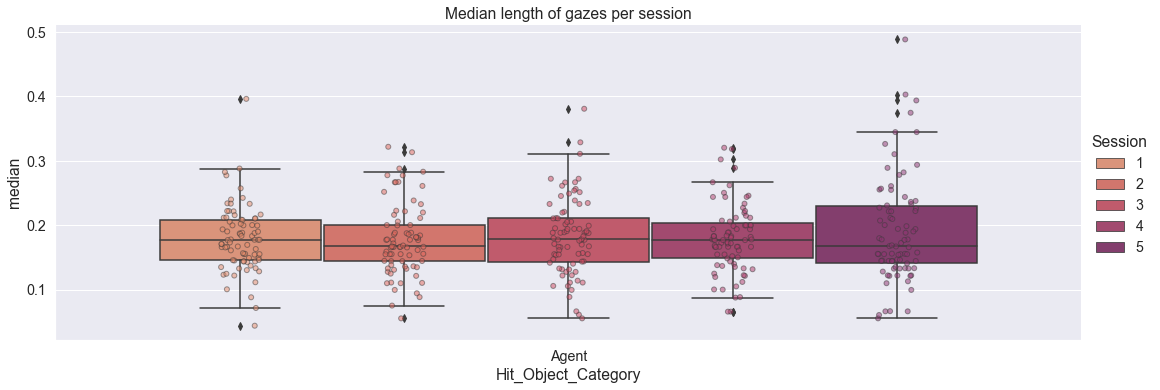

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Hit_Object_Category", y="median", hue="Session", data=summary_name_stats_fix_length_BIG[(summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent")], \
            height=5, aspect=3, kind='box').set(title="Median length of gazes per session")
ax = sns.stripplot(x="Hit_Object_Category", y="median", hue="Session", data=summary_name_stats_fix_length_BIG[summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent"], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/counts.png',  bbox_inches='tight')

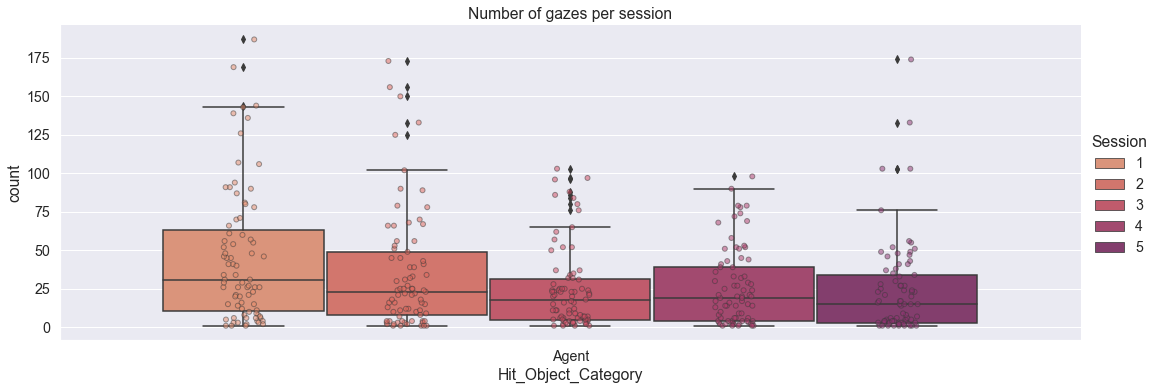

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(x="Hit_Object_Category", y="count", hue="Session", data=summary_name_stats_fix_length_BIG[(summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Hit_Object_Category", y="count", hue="Session", data=summary_name_stats_fix_length_BIG[summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent"], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/counts.png',  bbox_inches='tight')

In [ ]:
dy='Hit_Object_Category'; dx='count'; ort='h'; pal = sns.color_palette(); sigma = .2
f, ax = plt.subplots(figsize=(18, 15))

import ptitprince as pt

ax=pt.half_violinplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, palette = pal, bw = .2, cut = 0.,
                      scale = 'area', width = .6, inner = None, orient = ort)
ax=sns.stripplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, palette = pal, edgecolor = 'white',
                 size = 3, jitter = 1, zorder = 0, orient = ort)
ax=sns.boxplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, color = 'black', width = .15, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', 'zorder':10},\
            showfliers=True, whiskerprops = {'linewidth':2, 'zorder':10},\
            saturation = 1, orient = ort) 

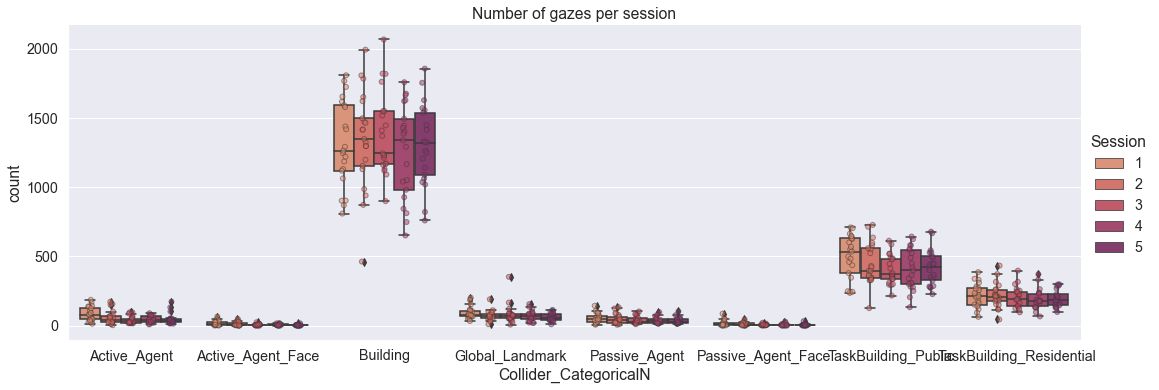

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="count", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="count",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/count.png')

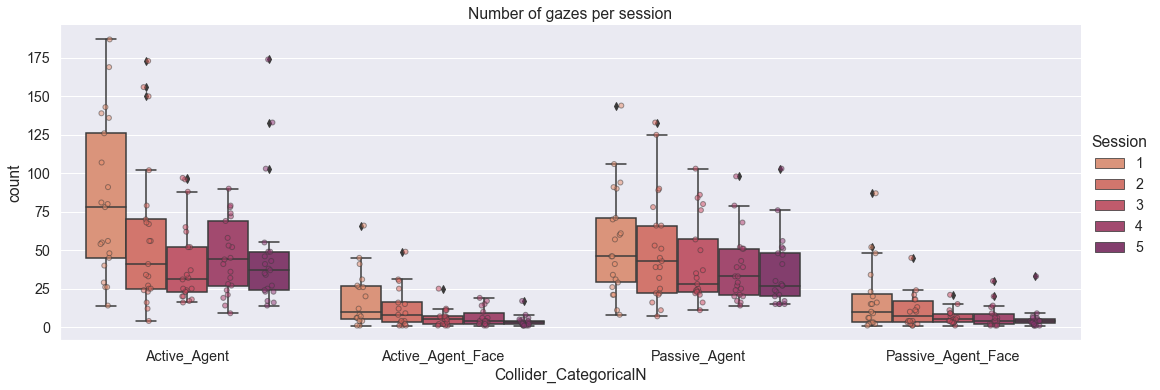

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="count", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="count",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
#plt.ylim(top=100)
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/count_Faces.png',  bbox_inches='tight')

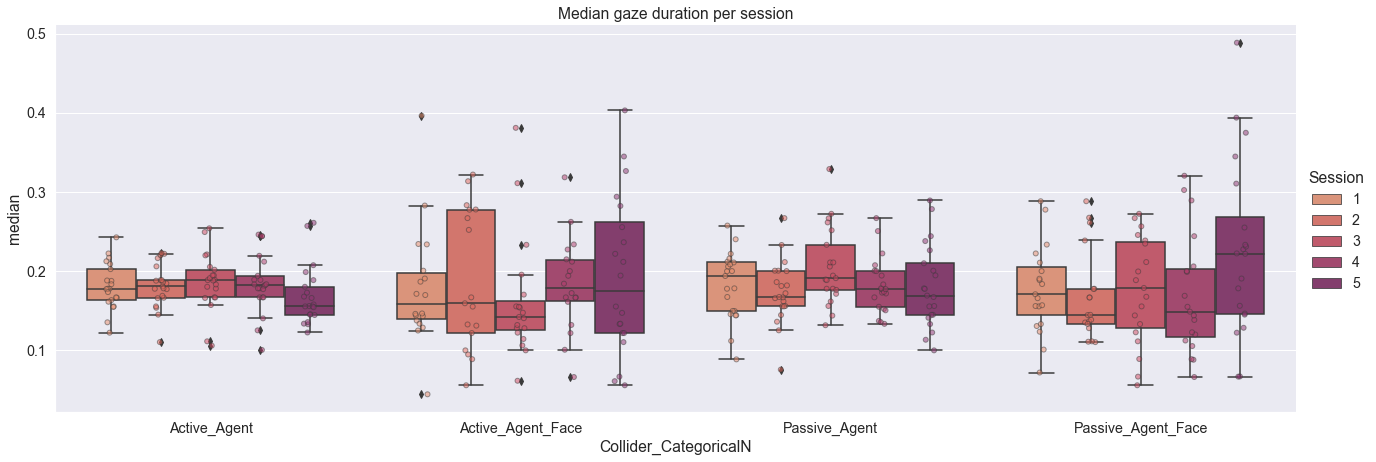

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="median", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=6, aspect=3, kind='box').set(title="Median gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="median",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/Median_Duration_Faces.png',  bbox_inches='tight')

In [56]:
data_frame_gaze_no_out_ONLY_TEST.tail()

Unnamed: 0   index  SubjectID  Session  SessionSubsection  \
15815377      108981  108981       9586        5                  3   
15819614      113218  113218       9586        5                  3   
15819952      113556  113556       9586        5                  3   
15820798      114402  114402       9586        5                  3   
15820974      114578  114578       9586        5                  3   

          timeStampDataPointEnd  combinedGazeValidityBitmask  \
15815377           1.655289e+09                            3   
15819614           1.655289e+09                            3   
15819952           1.655289e+09                            3   
15820798           1.655289e+09                            3   
15820974           1.655289e+09                            3   

          eyePositionCombinedWorld.x  eyePositionCombinedWorld.y  \
15815377                   79.019798                   -4.896025   
15819614                  113.661552                   -3.946193   
15819952                  110.496048                   -3.516545   
15820798                   98.682976                   -2.491314   
15820974                   95.453751                   -2.381682   

          eyePositionCombinedWorld.z  ...    avg_dist  \
15815377                 -229.422073  ...   29.525342   
15819614                 -167.269531  ...  114.957759   
15819952                 -150.648438  ...  100.384884   
15820798                 -115.873283  ...  517.734566   
15820974                 -111.614273  ...   47.386218   

                             names     Collider_CategoricalN  \
15815377           TaskBuilding_25       TaskBuilding_Public   
15819614        BasketballCourt_58       TaskBuilding_Public   
15819952           TaskBuilding_28       TaskBuilding_Public   
15820798  HighSilo-TaskBuilding_49           Global_Landmark   
15820974            TaskBuilding_4  TaskBuilding_Residential   

          Unnamed: 0.1.1.1  Unnamed: 0.1.1.1.1  Median_Standard_Duration  \
15815377               NaN                 NaN                  0.125037   
15819614               NaN                 NaN                  0.125037   
15819952               NaN                 NaN                  0.125037   
15820798               NaN                 NaN                  0.125037   
15820974               NaN                 NaN                  0.125037   

          gaze_mad_z  Outlier_Gaze_Length avatarID Hit_Object_Category  
15815377    0.682267                Stays     40.0            Building  
15819614    1.447856                Stays     20.0                 NaN  
15819952    0.214189                Stays     42.0            Building  
15820798    3.459006                Stays     56.0     Global_Landmark  
15820974    1.951634                Stays     29.0            Building  

[5 rows x 53 columns]

In [57]:
data_frame_gaze_no_out_ONLY_TEST.columns

Index(['Unnamed: 0', 'index', 'SubjectID', 'Session', 'SessionSubsection',
       'timeStampDataPointEnd', 'combinedGazeValidityBitmask',
       'eyePositionCombinedWorld.x', 'eyePositionCombinedWorld.y',
       'eyePositionCombinedWorld.z', 'eyeDirectionCombinedWorld.y',
       'eyeDirectionCombinedWorld.z', 'eyeDirectionCombinedLocal.x',
       'eyeDirectionCombinedLocal.y', 'eyeDirectionCombinedLocal.z',
       'playerBodyPosition.x', 'playerBodyPosition.y', 'playerBodyPosition.z',
       'hitColliderType', 'hitObjectColliderName', 'ordinalOfHit',
       'hitPointOnObject_x', 'hitPointOnObject_y', 'hitPointOnObject_z',
       'Eucledian_distance', 'Collider_Categorical', 'Face_Hits', 'Time_Shift',
       'Continuous_Time', 'Bitmask_flag', 'Interpolated_collider',
       ' eyePositionCombinedWorld.x', 'Collider_shift', 'counter',
       'Time_of_Gaze', 'Gaze', 'combined_vel', 'thresh', 'isFix',
       'corrected_vel', 'events', 'length', 'distance', 'avg_dist', 'names',
       'Colli

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID", "SessionSubsection"])['']

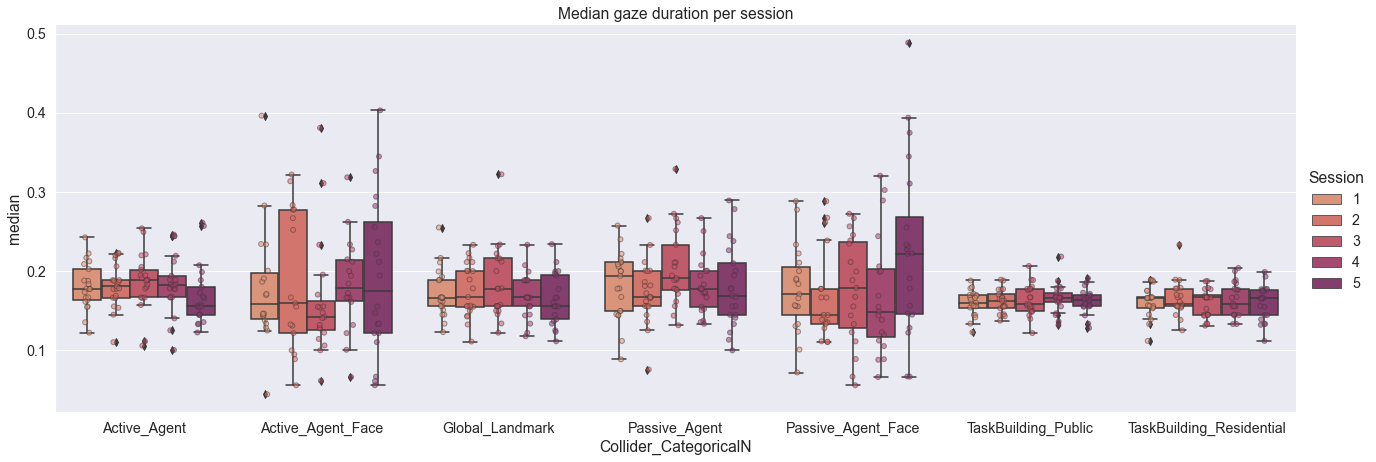

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="median", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=6, aspect=3, kind='box').set(title="Median gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="median",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/Median_Duration_All.png',  bbox_inches='tight')

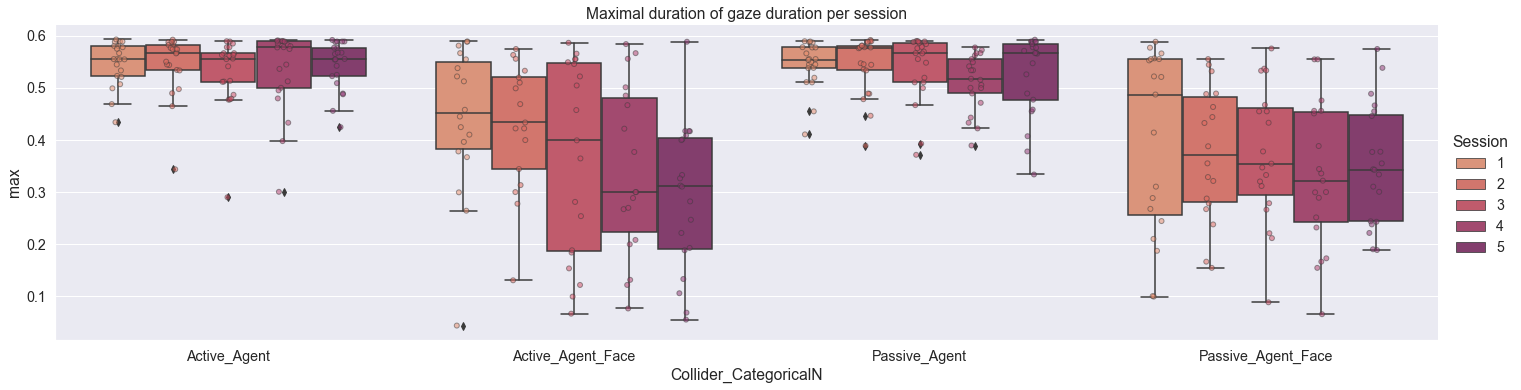

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="max", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=5, aspect=4, kind='box').set(title="Maximal duration of gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="max",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/MedianDurationFaces.png')

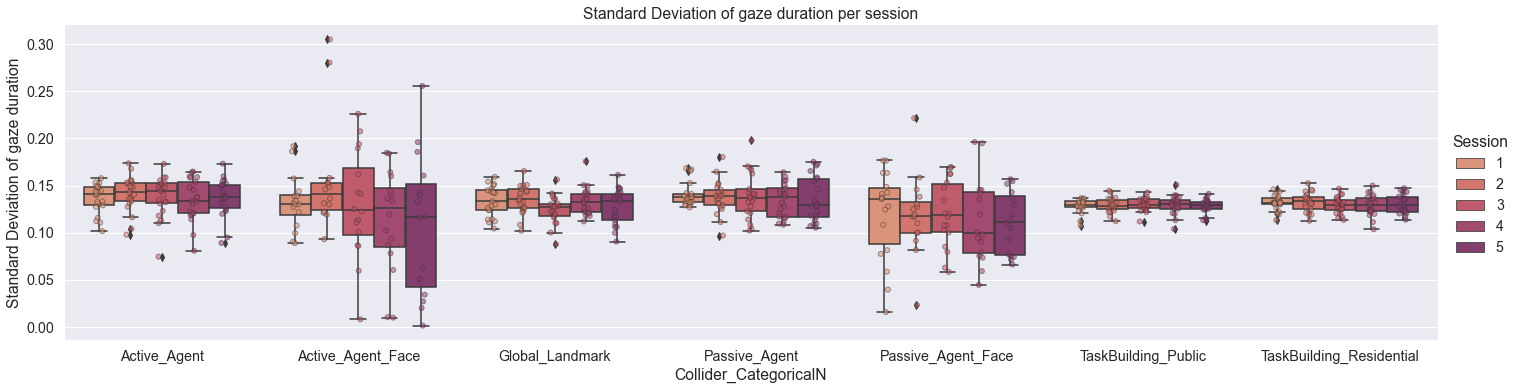

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="std", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=5, aspect=4, kind='box').set(title="Standard Deviation of gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="std",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
ax.set_ylabel("Standard Deviation of gaze duration")
plt.savefig('/Users/tracysanchezpacheco/Desktop/MedianDurationFaces.png', bbox_inches='tight')

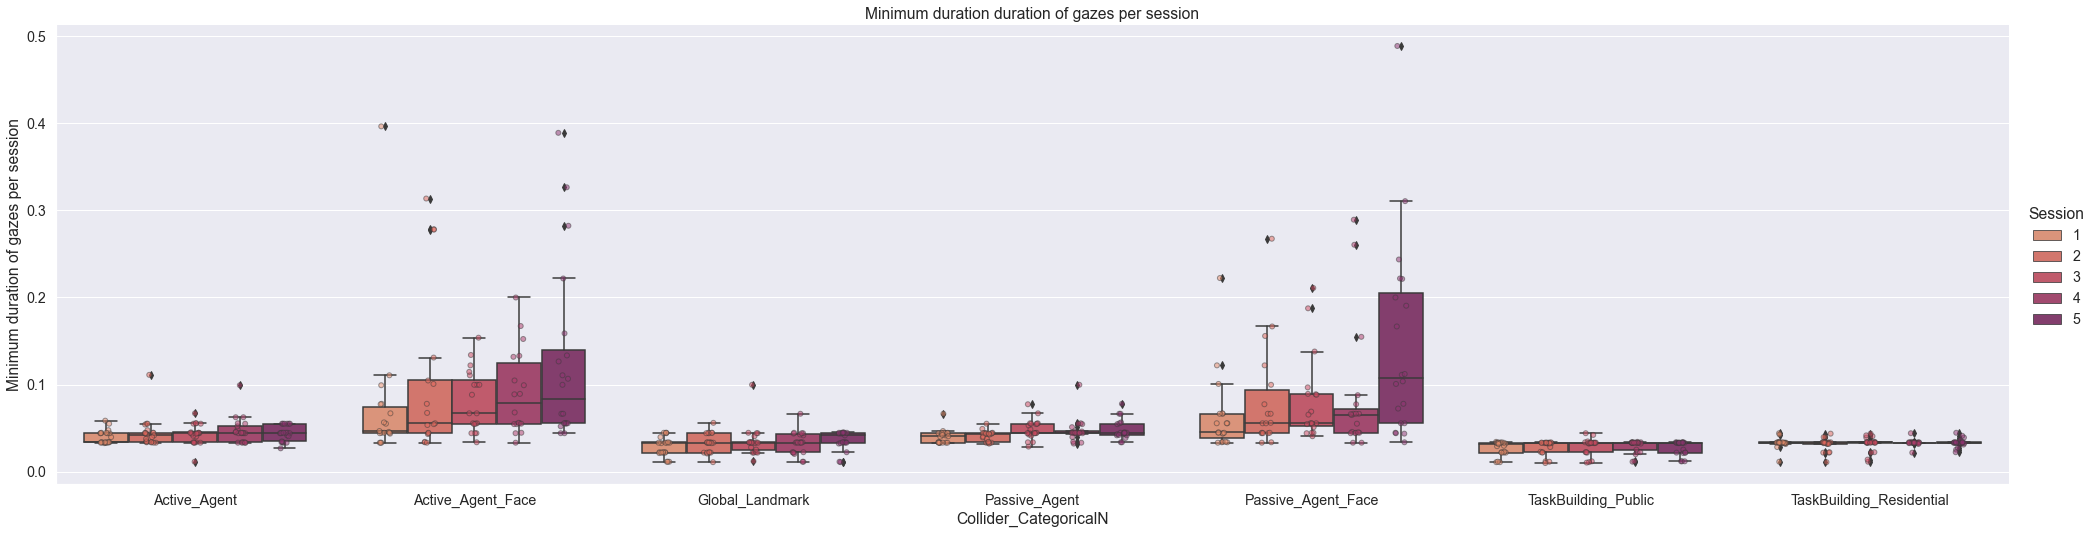

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="min", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=7, aspect=4, kind='box').set(title="Minimum duration duration of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="min",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
#plt.ylim(top=1)
ax.get_legend().remove()
ax.set_ylabel("Minimum duration of gazes per session")
plt.savefig('/Users/tracysanchezpacheco/Desktop/count.png', bbox_inches='tight')

In [ ]:
HumanA = pd.read_csv("/Users/tracysanchezpacheco/Documents/Resources/humanA_Behavioural.csv")

In [ ]:
HumanA["AE_Median_Standard_Duration"] = np.nanmedian(abs(HumanA.AbsolutError - np.nanmedian(HumanA.AbsolutError))) * 1.4826
HumanA["AE_mad_z"] = abs(HumanA.AbsolutError.tolist() - np.nanmedian(HumanA.AbsolutError)) / HumanA.AE_Median_Standard_Duration.tolist()
HumanA["Outlier_AE_Length"] = np.where(HumanA["AE_mad_z"] > 3.5, "Out", "Stays")
HumanA["RT_Median_Standard_Duration"] = np.nanmedian(abs(HumanA.RT - np.nanmedian(HumanA.RT))) * 1.4826
HumanA["RT_mad_z"] = abs(HumanA.RT.tolist() - np.nanmedian(HumanA.RT)) / HumanA.RT_Median_Standard_Duration.tolist()
HumanA["Outlier_RT_Length"] = np.where(HumanA["RT_mad_z"] > 3.5, "Out", "Stays")
HumanA_OUT = HumanA[(HumanA.Outlier_AE_Length != "Out") & (HumanA.Outlier_RT_Length != "Out")]
HumanA_OUT.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/HumanA_NoOut.cvs")

In [ ]:
data_frame.head(50)

In [ ]:
data_frame.info()

In [ ]:
data_frame.to_csv("/Volumes/SSD/00_Data_Processing/Pre_processed/Complete_Data_AngularV.cvs")

In [ ]:
One_participant.columns

In [ ]:
One_participant.drop(columns=['Unnamed: 0', 'level_0','Unnamed: 0.1', 'Unnamed: 0.1.1'], inplace=True)

In [ ]:
One_participant.events.value_counts()

In [ ]:
One_participant['avg_shift'] = One_participant['avg_dist'].shift(1) != One_participant['avg_dist']

In [ ]:
data_frame.iloc[115318:115322,6:9]

In [ ]:
data_frame.info()

In [ ]:
One_participant.iloc[115521:115532,45:50]

In [ ]:
One_participant.iloc[115318:115322,6]

In [ ]:
One_participant.iloc[115322,6] - One_participant.iloc[115318,6]

In [ ]:
One_participant.iloc[115532,6] - One_participant.iloc[115521,6]

In [ ]:
One_participant.tail(200)

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
df